In [1]:
import duckdb
import pandas as pd
import numpy as np
import time
import seaborn

In [5]:
demographics = pd.read_excel('Campus_dataset.xlsx', sheet_name='Demographic Data')
events = pd.read_excel('Campus_dataset.xlsx', sheet_name='Event Attendance')
performance = pd.read_excel('Campus_dataset.xlsx', sheet_name='Class Performance Data')
platform = pd.read_excel('Campus_dataset.xlsx', sheet_name='Platform Engagement')

## Exploratory data analysis of student demographics

In [268]:
conn = duckdb.connect()
demo_gen = conn.execute("""
SELECT DISTINCT COUNT(user_id) FROM demographics
             """).fetch_df()
# 1713 total students 

demo_gen


,count(user_id)
0,1713


In [269]:
conn.execute("""
SELECT gender, COUNT(*) FROM demographics
             Group by gender
             ORDER BY COUNT(*) DESC
             """).fetch_df()
# Most students are females at about 1203, followed by 466 for males, non-binary at 38 and 6 for other & none combined

,gender,count_star()
0,female,1203
1,male,466
2,no-binary,38
3,other,3
4,None,3


In [270]:
demographics.isna().sum()
# Most null values are in the Liftime GPA column,

user_id                          0
term_number                      0
hear_about_campus                0
gender                           3
age                              0
race                             0
hispanic                         0
high_school_grad                 0
ged_received                     0
parental_university_education    0
past_college_enrollment          0
zipcode                          0
city                             0
state                            2
veteran_status                   0
registration_status              0
Lifetime Credits Completed       0
Lifetime Credits Attempted       0
Lifetime_GPA                     0
dtype: int64

In [ ]:
demographics['Lifetime GPA'] = demographics['Lifetime GPA'].fillna(0)
demographics.isna().sum()
# nulls have been filled with 0 in lifetime GPA column

demographics = demographics.rename(columns={"Lifetime GPA": "Lifetime_GPA", })


KeyError: 'Lifetime GPA'

In [78]:
demographics['Lifetime_GPA'] = demographics['Lifetime_GPA'].astype('float64')
demographics['Lifetime_GPA'].describe()
#The mean being higher than the median suggests a positively skewed distribution.
# The fact that 25% of students have a GPA of 0.0 indicates a significant portion of the population has very low academic performance or possibly incomplete/missing data.
# There's a wide spread between the 25th percentile (0.0) and the 75th percentile (3.46), showing considerable disparity in academic performance.
# The mean of 1.66 is relatively low for a 4.0 scale, suggesting overall academic challenges in this population.

count    1713.000000
mean        1.664716
std         1.668987
min         0.000000
25%         0.000000
50%         1.333333
75%         3.461538
max         4.000000
Name: Lifetime_GPA, dtype: float64

0       yes
1       yes
2       yes
3       yes
4       yes
       ... 
1708     no
1709    yes
1710    yes
1711    yes
1712    yes
Name: high_school_grad, Length: 1713, dtype: object

In [ ]:
## race demographic summary statistics

demo_stats = conn.execute("""
WITH CTE AS (SELECT race, gender, AVG(Lifetime_GPA) AS avg_gpa, MEDIAN(Lifetime_GPA) AS median_gpa, 
                            AVG(Age), count(GENDER), Median(Age) AS median_age,
                    SUM(Lifetime_Credits_Attempted) AS sum_credits_attempted, 
                    SUM(Lifetime_Credits_Completed) AS sum_credits_completed,
                    SUM(CASE WHEN high_school_grad = 'yes' THEN 1 ELSE 0 END) AS Number_of_High_School_Graduates     
                FROM demographics 
                WHERE gender IS NOT NULL                 
             GROUP BY race, gender)
SELECT * EXCLUDE (dp.race)
FROM CTE C
LEFT JOIN demo_per dp ON C.race = dp.race AND C.gender = dp.gender
""").fetch_df()

demo_stats

In [460]:
# The average
gen_dmo = conn.execute("""
SELECT race, GENDER, AVG(Age), count(GENDER) FROM demographics
            WHERE gender IS NOT NULL
             GROUP BY GENDER, race
             """).fetch_df()
# The average
gen_dmo

,race,gender,avg(Age),count(GENDER)
0,black,male,29.643154,241
1,americanIndian,female,30.476190,21
2,white,no-binary,23.500000,16
3,asian,male,21.857143,14
4,mixed,other,25.000000,1
5,white,female,27.604938,405
6,americanIndian,no-binary,24.000000,2
7,nativeHawaiian,female,28.272727,11
8,mixed,no-binary,25.571429,7
9,white,other,20.000000,2


In [ ]:
conn.execute("""
SELECT AVG(Age), MAX(AGE), MIN(AGE) FROM demographics
             """).fetch_df()
# Average age of students is 28.6, oldeest being 75 and youngest being 18

,avg(Age),max(AGE),min(AGE)
0,28.595447,75,18


In [41]:
# preprocessing the data to modify the name of a column
demographics = demographics.rename(columns={"first_gen_college?": "parental_university_education"})
demographics['parental_university_education']

0       attended
1        neither
2       attended
3        neither
4       attended
          ...   
1708    attended
1709     unknown
1710     neither
1711     neither
1712     neither
Name: parental_university_education, Length: 1713, dtype: object

In [342]:
parent_edu_2 = conn.execute("""
WITH CTE AS (SELECT parental_university_education, COUNT(*) AS count FROM demographics
             GROUP BY parental_university_education
             ORDER BY COUNT(*) DESC)
             SELECT parental_university_education, count, count*100.0/(SELECT COUNT(*) FROM demographics) AS percentage FROM CTE
             """).fetch_df()

parent_edu_2.to_excel('parent_edu_2.xlsx')
# Most of our students are first generation students making almost half to be the first attending the university and 78 % would be first genereation graduates were they to graduate

In [341]:
parent_edu = conn.execute("""
    WITH CTE AS (
        SELECT 
            TRIM(race) AS race, 
            parental_university_education,
            COUNT(*) AS count 
        FROM demographics
        GROUP BY ALL
        ORDER BY COUNT(*) DESC
    )
    SELECT 
        race, 
        parental_university_education,
        count, 
        count*100.0/(SELECT COUNT(*) FROM demographics) AS percentage 
    FROM CTE
    ORDER BY 
        CASE 
            WHEN parental_university_education = 'neither' THEN 1 
            WHEN parental_university_education = 'attended' THEN 2
            WHEN parental_university_education = 'graduated' THEN 3
            WHEN parental_university_education = 'unknown' THEN 4 
        END, 
        count DESC
""").fetchdf()

parent_edu.to_excel('parent_edu.xlsx')

# Most of our students are black, about half. This provides insight on our student base as well as giving us a macro perspective on which demographic is underpriviledged
# Additionally black students (due to them being most studnets) have the highest instances of all occurane, however, almost half of them are first gen 

In [467]:
demo_per = conn.execute("""
    WITH CTE AS (
        SELECT 
            TRIM(race) AS race, gender,
            COUNT(*) AS count 
        FROM demographics
        GROUP BY TRIM(race), gender
        ORDER BY COUNT(*) DESC
    )
    SELECT 
        race,
        gender,
        count, 
        count*100.0/(SELECT COUNT(*) FROM demographics) AS percentage 
    FROM CTE
""").fetchdf()
demo_per

,race,gender,count,percentage
0,black,female,599,34.967893
1,white,female,405,23.642732
2,black,male,241,14.068885
3,mixed,female,156,9.106830
4,white,male,131,7.647402
5,mixed,male,71,4.144775
6,americanIndian,female,21,1.225919
7,white,no-binary,16,0.934034
8,asian,male,14,0.817280
9,black,no-binary,13,0.758903


In [ ]:
geo_count = conn.execute("""
    SELECT state, COUNT(*) as count
            FROM demographics
            GROUP BY state
            Order by count desc
             """).fetch_df()
# Texas has the majority of our students

,state,count
0,TX,208
1,CA,146
2,GA,144
3,FL,122
4,OH,91
5,PA,70
6,IL,65
7,NY,57
8,MI,56
9,SC,55


In [ ]:
conn.execute("""
        SELECT veteran_status, COUNT(*) as count
             FROM demographics
             GROUP BY ALL 
            ORDER BY count desc
             """).fetch_df()
# Most students are not veterans, it's not a major consumer base only hold 5% of our users.

,veteran_status,count
0,not veteran,1625
1,veteran,88


In [ ]:
conn.execute("""
        SELECT high_school_grad, COUNT(*) AS count
             FROM demographics
             GROUP BY ALL
             ORDER BY count DESC
             """).fetch_df()
# Most of our students did graduate high school at about 94% while 7% got their GED instead

,high_school_grad,count
0,yes,1603
1,no,110


In [340]:
marketing = conn.execute("""
        WITH CTE AS (SELECT hear_about_campus AS Mark_channel, COUNT(*) AS count
             FROM demographics
             GROUP BY ALL)
             SELECT *, count*100.0/(SELECT COUNT(*) FROM demographics) AS percentage 
             FROM CTE 
             ORDER BY percentage DESC
             """).fetch_df()

# Facebook proves to be our greatest marketing channel With a 32.7% reach, followed by 20.8% from instagram
# Meta platforms seem to be our most lucrative marketing channel with 50%+ level of reach
marketing.to_excel('marketing.xlsx')

## Changed the shape of the events data to be more interpretable

In [339]:
# Convert from wide to long format
events_long = events.melt(
    id_vars='user_id', 
    var_name='event_name', 
    value_name='status'
)

# Create boolean attendance columns
events_long['present'] = events_long['status'] == 'Present'
events_long['absent'] = events_long['absent'] = (events_long['status'] == 'Absent') | (events_long['status'].isna()) | (events_long['status'] == '')

# Pivot to user-level event summary
event_summary = events_long.groupby('user_id').agg({
    'present': 'sum',
    'absent': 'sum'
}).reset_index()
event_summary.columns = ['user_id', 'total_events_present', 'total_events_absent']

# Calculate total events for each user (optional)
event_summary['total_events'] = event_summary['total_events_present'] + event_summary['total_events_absent']

event_summary.to_excel('event_summary.xlsx', index=False)

## Does demographics effect the event attendance ?

In [338]:
# Merge event summary with demographics
demographics_events = demographics.merge(event_summary, on='user_id', how='left')

race_attendance = conn.execute("""
    WITH CTE AS (SELECT race, SUM(total_events_present) AS sum_events_attended, sum(total_events_absent) AS sum_events_missed, avg(Lifetime_GPA) AS avg_gpa_per_race
             FROM demographics_events
             GROUP BY race)
                SELECT *, sum_events_attended + sum_events_missed AS total_events, sum_events_attended*100.0/(sum_events_attended + sum_events_missed) AS percentage_attended, sum_events_missed*100.0/(sum_events_attended + sum_events_missed) AS percentage_missed
                FROM CTE 
                ORDER BY sum_events_missed DESC
             """).fetch_df()
race_attendance
race_attendance.to_excel('race_attendance.xlsx')

# Most students have a low rate of participation in events.
# The black student cohort has the highest number of missed events, which could be due to a variety of reasons, including lack of interest, lack of time, or lack of awareness.

In [336]:
demp_events = event_summary.merge(demographics, on='user_id', how='left')

user_gpa_presence = conn.execute("""
    SELECT
        user_id,
        MAX(lifetime_gpa) AS lifetime_gpa,
        total_events_present,
        total_events_absent
    FROM demp_events
    GROUP BY ALL
    ORDER BY lifetime_gpa DESC
             """).fetch_df()
user_gpa_presence.to_csv('user_gpa_presence.csv', index=False)
# There is no clear correlation between GPA and event attendance. Students with high GPAs have low attendance rates, and the same is true for students with low GPAs.

## Student performance 

In [ ]:
performance['avg_assigment_grade']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4239 entries, 0 to 4238
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   user_id                                 4239 non-null   int64  
 1   course_name                             4239 non-null   object 
 2   avg_attendance                          4239 non-null   float64
 3   avg_assignment_grade                    4239 non-null   float64
 4   avg_assignment_submission_rate          4239 non-null   float64
 5   avg_on_time_assignment_submission_rate  4239 non-null   float64
 6   class_status                            4239 non-null   object 
 7   final_grade                             4239 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 265.1+ KB


In [205]:
performance_agg = conn.execute("""
    SELECT
        user_id,
        AVG(avg_attendance) AS avg_attendance,
        AVG(avg_assignment_grade) AS avg_assignment_grade,
        AVG(
             CASE WHEN class_status = 'Completed' THEN 1 ELSE 0 END
        ) AS completion_rate
            
    FROM performance
    GROUP BY ALL
             """).fetch_df()

performance_agg

,user_id,avg_attendance,avg_assignment_grade,completion_rate
0,458,0.742063,0.471706,1.0
1,257,0.907477,0.778019,1.0
2,332,0.793651,0.618565,1.0
3,184,0.884632,0.985566,1.0
4,172,0.838889,0.947470,1.0
...,...,...,...,...
1640,686,1.000000,0.995555,1.0
1641,1251,0.972222,0.559001,1.0
1642,653,0.416667,0.424488,1.0
1643,8,0.000000,0.000000,0.0


In [200]:
conn.execute("""
    SELECT * FROM performance_agg
             ORDER BY completion_rate 
             """).fetch_df()

,user_id,avg_attendance,avg_assignment_grade,completion_rate
0,615,0.687500,0.582425,0.0
1,338,0.450355,0.716326,0.0
2,476,0.640418,0.404899,0.0
3,238,0.387418,0.514549,0.0
4,1089,0.354575,0.572088,0.0
...,...,...,...,...
1640,1342,0.833333,0.801153,1.0
1641,1694,0.944444,0.961078,1.0
1642,654,0.972222,0.605676,1.0
1643,1601,1.000000,0.983327,1.0


## There are identifiable correlations between many of the features of the data set

In [137]:
numeric_performance = performance.select_dtypes(include=[float, int])

# Compute the correlation matrix
correlation_matrix = numeric_performance.corr()

# Display the correlation matrix
correlation_matrix

,user_id,avg_attendance,avg_assignment_grade,avg_assignment_submission_rate,avg_on_time_assignment_submission_rate
user_id,1.000000,-0.097649,-0.051604,-0.083701,-0.079391
avg_attendance,-0.097649,1.000000,0.739600,0.692243,0.603319
avg_assignment_grade,-0.051604,0.739600,1.000000,0.908607,0.786779
avg_assignment_submission_rate,-0.083701,0.692243,0.908607,1.000000,0.828346
avg_on_time_assignment_submission_rate,-0.079391,0.603319,0.786779,0.828346,1.000000


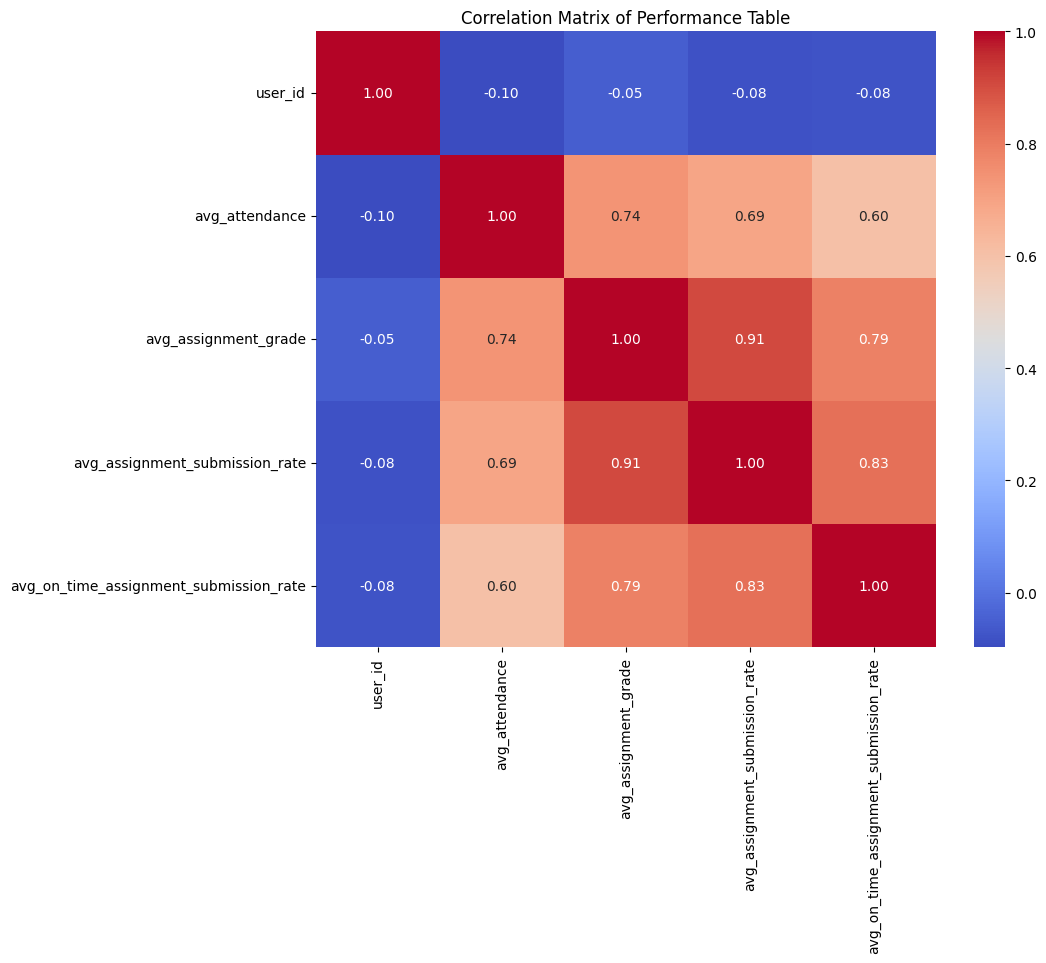

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Performance Table')
plt.show()

## The correlation matrix shows that there is a strong positive correlation between the average assignment grade and the completion rate, which is expected.

In [139]:
numeric_performance_agg = performance_agg.select_dtypes(include=[float, int])

# Compute the correlation matrix
correlation_matrix_agg = numeric_performance_agg.corr()

# Display the correlation matrix
correlation_matrix_agg

,user_id,avg_attendance,avg_assignment_grade,completion_rate
user_id,1.000000,-0.078052,-0.031910,-0.080023
avg_attendance,-0.078052,1.000000,0.819228,0.782352
avg_assignment_grade,-0.031910,0.819228,1.000000,0.621704
completion_rate,-0.080023,0.782352,0.621704,1.000000


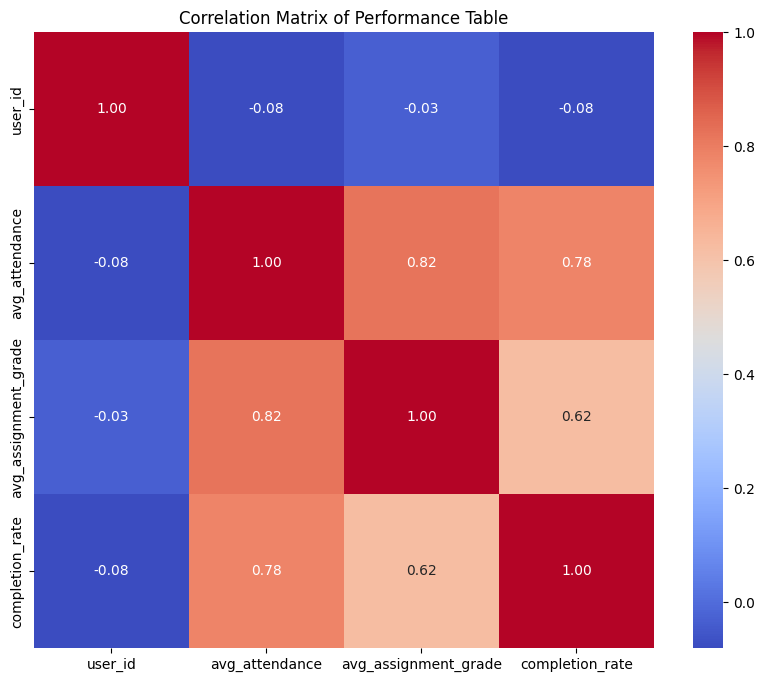

In [140]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_agg, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Performance Table')
plt.show()

## Platform Engagement 

In [ ]:
plat_mesg_avg = platform['avg_messages_sent_per_week'].mean()
# avg messages sent per week is 9.7 messages across campuses engament platform
platform['avg_cw_connections_per_week'].mean()
# avg connections per week is 47.9 connections across campuses engament platform

np.float64(47.87179366940211)

In [203]:
plat_agg = conn.execute("""
    SELECT d.user_id, p.avg_messages_sent_per_week, p.avg_cw_connections_per_week, d.Lifetime_GPA, 
             AVG(avg_messages_sent_per_week) OVER() AS w_avg_messages_sent_per_week,
             AVG(avg_cw_connections_per_week) OVER() AS w_avg_cw_connections_per_week,
            MEDIAN(avg_messages_sent_per_week) OVER() AS w_median_messages_sent_per_week,
            MEDIAN(avg_cw_connections_per_week) OVER() AS w_median_cw_connections_per_week
             FROM platform p
             LEFT JOIN demographics d ON p.user_id = d.user_id
             ORDER BY Lifetime_GPA DESC
             """).fetch_df()

plat_agg

## Upon first glance there seems to be positive correlation between GPA and the number of messages sent per week.

,user_id,avg_messages_sent_per_week,avg_cw_connections_per_week,Lifetime_GPA,w_avg_messages_sent_per_week,w_avg_cw_connections_per_week,w_median_messages_sent_per_week,w_median_cw_connections_per_week
0,19,4.08,14.64,4.0,9.662242,47.871794,5.5,21.65
1,27,1.18,35.42,4.0,9.662242,47.871794,5.5,21.65
2,32,59.22,133.14,4.0,9.662242,47.871794,5.5,21.65
3,53,7.68,353.88,4.0,9.662242,47.871794,5.5,21.65
4,63,9.92,30.24,4.0,9.662242,47.871794,5.5,21.65
...,...,...,...,...,...,...,...,...
1702,794,3.64,2.72,0.0,9.662242,47.871794,5.5,21.65
1703,935,3.06,6.66,0.0,9.662242,47.871794,5.5,21.65
1704,1335,16.82,10.24,0.0,9.662242,47.871794,5.5,21.65
1705,1332,8.64,32.28,0.0,9.662242,47.871794,5.5,21.65


### The data above proves to display a form of Right Skewness in the distribution which indicates there are a small pool of highly active users on the platform that drive the average platform usage up, this is indicated by the large variance between the median and avarage

### Mean of 9.7 vs. median of 5.5 means half of your users send 5.5 or fewer messages per week when it comes to DMs

### Mean of 47.9 vs. median of 21.7 shows an even more dramatic skew. Half the users make 21.7 or fewer connections per week

## This pattern is extremely common in digital platforms and follows what's often called the "90-9-1 rule" or variations of participation inequality:
### A small percentage of users (perhaps 1-10%) are super-users or power users
### A larger percentage (perhaps 10-30%) are moderately active
### The majority (perhaps 60-90%) are low-engagement users



In [174]:
plat_high_academic = plat_agg[plat_agg['Lifetime_GPA'] >= 3.0]
plat_high_academic 


,user_id,avg_messages_sent_per_week,avg_cw_connections_per_week,Lifetime_GPA,w_avg_messages_sent_per_week,w_avg_cw_connections_per_week,w_median_messages_sent_per_week,w_median_cw_connections_per_week
0,19,4.08,14.64,4.0,9.662242,47.871794,5.5,21.65
1,27,1.18,35.42,4.0,9.662242,47.871794,5.5,21.65
2,32,59.22,133.14,4.0,9.662242,47.871794,5.5,21.65
3,53,7.68,353.88,4.0,9.662242,47.871794,5.5,21.65
4,63,9.92,30.24,4.0,9.662242,47.871794,5.5,21.65
...,...,...,...,...,...,...,...,...
571,1670,30.82,317.26,3.0,9.662242,47.871794,5.5,21.65
572,850,3.06,18.90,3.0,9.662242,47.871794,5.5,21.65
573,1460,15.86,135.32,3.0,9.662242,47.871794,5.5,21.65
574,1530,3.60,30.48,3.0,9.662242,47.871794,5.5,21.65


In [417]:
plat_high_academic_stat = conn.execute("""
    SELECT  AVG(avg_messages_sent_per_week), AVG(avg_cw_connections_per_week), MEDIAN(avg_messages_sent_per_week), MEDIAN(avg_cw_connections_per_week)
             FROM plat_high_academic 
             """).fetch_df()

plat_high_academic_stat.to_excel('plat_high_academic_stat.xlsx')

In [176]:
plat_low_academic = plat_agg[plat_agg['Lifetime_GPA'] < 3.0]
plat_low_academic 

,user_id,avg_messages_sent_per_week,avg_cw_connections_per_week,Lifetime_GPA,w_avg_messages_sent_per_week,w_avg_cw_connections_per_week,w_median_messages_sent_per_week,w_median_cw_connections_per_week
576,82,4.96,13.74,2.967742,9.662242,47.871794,5.5,21.65
577,240,4.56,37.76,2.965517,9.662242,47.871794,5.5,21.65
578,495,4.24,35.64,2.933333,9.662242,47.871794,5.5,21.65
579,742,19.76,44.20,2.933333,9.662242,47.871794,5.5,21.65
580,381,6.36,69.84,2.925000,9.662242,47.871794,5.5,21.65
...,...,...,...,...,...,...,...,...
1702,794,3.64,2.72,0.000000,9.662242,47.871794,5.5,21.65
1703,935,3.06,6.66,0.000000,9.662242,47.871794,5.5,21.65
1704,1335,16.82,10.24,0.000000,9.662242,47.871794,5.5,21.65
1705,1332,8.64,32.28,0.000000,9.662242,47.871794,5.5,21.65


In [418]:
plat_low_academic_stat = conn.execute("""
    SELECT  AVG(avg_messages_sent_per_week), AVG(avg_cw_connections_per_week), MEDIAN(avg_messages_sent_per_week), MEDIAN(avg_cw_connections_per_week)
             FROM plat_low_academic 
             """).fetch_df()
plat_low_academic_stat.to_excel('plat_low_academic_stat.xlsx')

### We are able to see that students with a 3.0 and above lifetime GPA show a higher than averge DMs per week as well as higher than avegrage platform engament, whereas students with Lifetime GPAs had a lower than average engagement and DMs overall. This provides insight that the more a user interacts with the platform, the likelyhood that their GPA goes up.

# Addressing business Questions

In [277]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.stats as stats

In [316]:
event_cols = ['user_id', 'total_events_present', 'total_events_absent', 'total_events']
event_data = demographics_events[event_cols].drop_duplicates(subset=['user_id'])
demo_cols = [
    'user_id', 'gender', 'race', 'age', 'parental_university_education',
    'high_school_grad', 'past_college_enrollment'
]
demo_data = demographics[demo_cols].drop_duplicates(subset=['user_id'])

# Create unified dataset without corrupting the original data
unified_data = plat_agg.copy()
unified_data = unified_data.merge(event_data, on='user_id', how='left')
unified_data = unified_data.merge(performance_agg, on='user_id', how='left')
unified_data = unified_data.merge(demo_data, on='user_id', how='left')


In [484]:
# Event performance

event_performance = conn.execute("""
    WITH CTE AS (SELECT event_name, SUM(CASE WHEN present = 'True' THEN 1 ELSE 0 END) attendance_for_event, SUM(CASE WHEN absent = 'True' THEN 1 ELSE 0 END) AS absences_for_event,
                COUNT(*) AS total_attendance
             FROM events_long
             GROUP BY event_name)
             SELECT * EXCLUDE(total_attendance), attendance_for_event*100.0/total_attendance AS percentage_attended, absences_for_event*100.0/total_attendance AS percentage_absent
             FROM CTE
             ORDER BY percentage_attended DESC
             """).fetch_df()

event_performance.to_excel('event_performance.xlsx')

In [317]:
### Data preprocessing
numeric_cols = unified_data.select_dtypes(include=['float64', 'int64']).columns
unified_data[numeric_cols] = unified_data[numeric_cols].fillna(0)

categorical_cols = unified_data.select_dtypes(include=['object']).columns
unified_data[categorical_cols] = unified_data[categorical_cols].fillna('Unknown')

unified_data['first_gen'] = unified_data['parental_university_education'] == 'neither'

In [407]:
# checking for the relative grades per course to examine if any course is more difficult than the other
# or rather is one course failing it's students more than the other
course_grades = conn.execute("""
  WITH GradeStats AS (
    SELECT 
        course_name,
        final_grade,
        COUNT(*) AS grade_count,
        AVG(avg_assignment_grade) AS avg_assignment_grade
    FROM performance
    GROUP BY course_name, final_grade
),
CourseTotals AS (
    SELECT
        course_name,
        COUNT(*) AS total_students,
        AVG(avg_assignment_grade) AS overall_avg_grade
    FROM performance
    GROUP BY course_name
)
SELECT 
    g.course_name,
    g.final_grade,
    g.grade_count,
    g.grade_count * 100.0 / c.total_students AS percentage_in_course,
    c.overall_avg_grade,
    c.total_students
FROM GradeStats g
JOIN CourseTotals c ON g.course_name = c.course_name
ORDER BY 
    g.course_name,
    CASE g.final_grade
        WHEN 'A' THEN 1
        WHEN 'B' THEN 2
        WHEN 'C' THEN 3
        WHEN 'D' THEN 4
        WHEN 'F' THEN 5
        WHEN 'W' THEN 6
        WHEN 'DNS' THEN 7
        ELSE 8
    END
             """).fetch_df()

course_grade_proportion = conn.execute("""
    WITH CTE AS (SELECT  * , ROW_NUMBER() OVER(PARTITION BY course_name ORDER BY percentage_in_course DESC, grade_count DESC) AS row_num
             FROM course_grades)
                SELECT * FROM CTE
                WHERE row_num = 1
             ORDER BY final_grade, percentage_in_course DESC
             """).fetch_df()
## The AI for business course has the highest proportion of students with an A grade.

course_grade_proportion.to_excel('course_grade_proportion.xlsx')

In [412]:
failure_rates  = conn.execute("""
             SELECT 
    course_name,
    AVG(avg_assignment_grade) as avg_course_grade,
    COUNT(*) as student_count,
    COUNT(CASE WHEN final_grade = 'F' THEN 1 END) as failing_students,
    COUNT(CASE WHEN final_grade = 'F' THEN 1 END) * 100.0 / COUNT(*) as failure_rate
FROM performance
GROUP BY course_name
ORDER BY failure_rate DESC
                """).fetch_df()

## advanced compostion has the highest failure rate at 22.4%, almost a quarter of the students fail this course
failure_rates

,course_name,avg_course_grade,student_count,failing_students,failure_rate
0,Advanced Composition,0.588035,134,30,22.388060
1,Principles of Marketing,0.633701,157,35,22.292994
2,Small Business Management,0.346014,28,6,21.428571
3,Business Skills: Presentation Skills,0.480549,53,11,20.754717
4,English Composition,0.447717,1011,198,19.584570
5,College Success,0.533775,1142,221,19.352014
6,Environmental Science and Ecological Living,0.671952,48,9,18.750000
7,Business & Professional Ethics,0.806706,116,20,17.241379
8,Introduction to Business,0.528984,999,171,17.117117
9,Introduction to Logic & Critical Thinking,0.633498,151,25,16.556291


In [ ]:
grade_course_freq = conn.execute("""
                        WITH GradeCounts AS (
    SELECT 
        course_name,
        final_grade,
        COUNT(*) AS grade_count
    FROM performance
    GROUP BY course_name, final_grade
),
RankedGrades AS (
    SELECT
        course_name,
        final_grade,
        grade_count,
        RANK() OVER(PARTITION BY final_grade ORDER BY grade_count DESC) AS grade_rank
    FROM GradeCounts
)
SELECT 
    course_name,
    final_grade AS most_common_grade,
    grade_count,
    grade_count * 100.0 / (SELECT COUNT(*) FROM performance WHERE course_name = r.course_name) AS percentage_of_course
FROM RankedGrades r
WHERE grade_rank = 1
ORDER BY grade_count DESC
                """).fetch_df()
grade_course_freq

In [471]:
grade_course_freq_prop = conn.execute("""
WITH GradeCounts AS (
    SELECT 
        course_name,
        final_grade,
        COUNT(*) AS grade_count,
        COUNT(*) * 100.0 / (SELECT COUNT(*) FROM performance p WHERE p.course_name = performance.course_name) AS grade_percentage
    FROM performance
    GROUP BY course_name, final_grade
),
RankedGrades AS (
    SELECT
        course_name,
        final_grade,
        grade_count,
        grade_percentage,
        RANK() OVER(PARTITION BY final_grade ORDER BY grade_percentage DESC) AS grade_rank
    FROM GradeCounts
    WHERE grade_count >= 5  -- Optional: minimum count to avoid very small classes skewing results
)
SELECT 
    final_grade,
    course_name AS course_with_highest_percentage,
    grade_count,
    grade_percentage AS percentage_of_course,
    (SELECT COUNT(*) FROM performance p WHERE p.course_name = r.course_name) AS total_course_enrollment
FROM RankedGrades r
WHERE grade_rank = 1
ORDER BY final_grade
                """).fetch_df()

grade_course_freq_prop

,final_grade,course_with_highest_percentage,grade_count,percentage_of_course,total_course_enrollment
0,A,AI for Business,35,72.916667,48
1,B,Quantitative Reasoning,12,21.052632,57
2,C,Introduction to Logic & Critical Thinking,25,16.556291,151
3,D,Environmental Science and Ecological Living,5,10.416667,48
4,DNS,Introduction to Business,96,9.609610,999
5,F,Advanced Composition,30,22.388060,134
6,W,Small Business Management,14,50.000000,28


In [318]:
### Sggregating the data

# Academic Performance Levels
unified_data['academic_level'] = pd.cut(
    unified_data['Lifetime_GPA'],
    bins=[0, 2.0, 2.5, 3.0, 3.5, 4.0],
    labels=['Poor', 'Below Average', 'Average', 'Good', 'Excellent'],
    include_lowest=True
)

# Platform Engagement Levels 
# For Messages
median_messages = 5.5  
mean_messages = 9.7   

unified_data['messaging_level'] = pd.cut(
    unified_data['avg_messages_sent_per_week'],
    bins=[0, median_messages/2, median_messages, mean_messages, float('inf')],
    labels=['Inactive', 'Low', 'Medium', 'High'],
    include_lowest=True
)

# For Connections
median_connections = 21.7  
mean_connections = 47.9  

unified_data['connection_level'] = pd.cut(
    unified_data['avg_cw_connections_per_week'],
    bins=[0, median_connections/2, median_connections, mean_connections, float('inf')],
    labels=['Inactive', 'Low', 'Medium', 'High'],
    include_lowest=True
)

In [ ]:
# Overall Platform Engagement Level (combining messages and connections)
from sklearn.preprocessing import MinMaxScaler

# Create normalized versions of engagement metrics
scaler = MinMaxScaler()
engagement_metrics = ['avg_messages_sent_per_week', 'avg_cw_connections_per_week']
normalized_metrics = pd.DataFrame(
    scaler.fit_transform(unified_data[engagement_metrics]),
    columns=['norm_messages', 'norm_connections']
)
unified_data[['norm_messages', 'norm_connections']] = normalized_metrics

unified_data['platform_engagement_score'] = (
    unified_data['norm_messages'] * 0.5 + 
    unified_data['norm_connections'] * 0.5
)

# Categorize the engagement score
unified_data['platform_engagement_level'] = pd.qcut(
    unified_data['platform_engagement_score'],
    q=4,
    labels=['Very Low', 'Low', 'Medium', 'High']
)

# Course Engagement Levels
# Using course attendance and assignment grades
unified_data['course_attendance_level'] = pd.cut(
    unified_data['avg_attendance'],
    bins=[0, 0.6, 0.8, 0.9, 1.0],
    labels=['Poor', 'Moderate', 'Good', 'Excellent'],
    include_lowest=True
)

# If assignment grades are percentages (0-100)
if 'avg_assignment_grade' in unified_data.columns:
    unified_data['assignment_grade_level'] = pd.cut(
        unified_data['avg_assignment_grade'],
        bins=[0, 60, 70, 80, 90, 100],
        labels=['F', 'D', 'C', 'B', 'A'],
        include_lowest=True
    )

# Event Attendance Levels
# Since attendance is very low (1%), even attending 1 event is significant
unified_data['event_attendance_level'] = pd.cut(
    unified_data['total_events_present'],
    bins=[-1, 0, 1, 2, float('inf')],
    labels=['None', 'One Event', 'Two Events', 'Multiple Events'],
    include_lowest=True
)

In [ ]:
def determine_primary_motivation(row):
    """Determine a student's primary motivation based on their engagement patterns"""
    
    # High academic performance but low platform engagement
    if row['academic_level'] in ['Good', 'Excellent'] and row['platform_engagement_level'] in ['Very Low', 'Low']:
        return 'Academic-Driven'
    
    # High platform engagement but lower academic performance
    elif row['platform_engagement_level'] in ['Medium', 'High'] and row['academic_level'] in ['Poor', 'Below Average', 'Average']:
        return 'Socially-Driven'
    
    # High in both academics and platform engagement
    elif row['academic_level'] in ['Good', 'Excellent'] and row['platform_engagement_level'] in ['Medium', 'High']:
        return 'All-Around Engaged'
    
    # Low in both academics and platform engagement
    elif row['academic_level'] in ['Poor', 'Below Average'] and row['platform_engagement_level'] in ['Very Low', 'Low']:
        return 'Disengaged'
    
    # Medium in academics and low in engagement, focused on passing
    elif row['academic_level'] == 'Average' and row['platform_engagement_level'] in ['Very Low', 'Low']:
        return 'Minimally-Involved'
    
    # Doesn't fit cleanly in other categories
    else:
        return 'Mixed-Profile'

unified_data['primary_motivation'] = unified_data.apply(determine_primary_motivation, axis=1)


In [ ]:
# Step 4: Unsupervised Clustering Analysis


# Select key features for clustering
cluster_features = [
    'Lifetime_GPA', 
    'avg_messages_sent_per_week', 
    'avg_cw_connections_per_week', 
    'avg_attendance',
    'completion_rate'
]

# Prepare data for clustering
cluster_data = unified_data[cluster_features].copy()
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Determine optimal number of clusters
from sklearn.metrics import silhouette_score

silhouette_scores = []
inertia_values = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Calculate inertia (within-cluster sum of squares)
    inertia_values.append(kmeans.inertia_)

# Find optimal k from silhouette scores
optimal_k = k_range[np.argmax(silhouette_scores)]

# Apply KMeans with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
unified_data['kmeans_cluster'] = kmeans.fit_predict(scaled_data)

# Get cluster centers and transform back to original scale
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=cluster_features
)

In [ ]:
# Regression for kmeans clusters

# Split data by cluster
cluster0_data = unified_data[unified_data['kmeans_cluster'] == 0]  # High-performing engaged students
cluster1_data = unified_data[unified_data['kmeans_cluster'] == 1]  # Struggling disengaged students

# Print sizes to confirm the split
print(f"Cluster 0 size: {len(cluster0_data)} students")
print(f"Cluster 1 size: {len(cluster1_data)} students")

# Define predictor variables (same as your original regression)
X_cols = ['avg_messages_sent_per_week', 'avg_cw_connections_per_week', 
         'avg_attendance', 'completion_rate']

# Prepare data for Cluster 0
X0 = cluster0_data[X_cols].fillna(0)
y0 = cluster0_data['Lifetime_GPA']

# Fit regression model
model0 = LinearRegression()
model0.fit(X0, y0)

# Get coefficients and create dataframe for display
coef_df0 = pd.DataFrame({
    'Variable': X_cols,
    'Coefficient': model0.coef_,
    'Abs_Coefficient': np.abs(model0.coef_)
})

# Sort by absolute coefficient size
coef_df0 = coef_df0.sort_values('Abs_Coefficient', ascending=False)

# Calculate R-squared
r_squared0 = model0.score(X0, y0)

# Display results
print("\n----- REGRESSION ANALYSIS FOR CLUSTER 0 (HIGH-PERFORMING) -----")
print(coef_df0)
print(f"R² Score: {r_squared0:.4f}")
print(f"Intercept: {model0.intercept_:.4f}")

# Interpret the results
print("\nInterpretation for Cluster 0:")
for _, row in coef_df0.iterrows():
    if row['Coefficient'] > 0:
        print(f"- Every 1 unit increase in {row['Variable']} is associated with a {row['Coefficient']:.3f} point increase in GPA")
    else:
        print(f"- Every 1 unit increase in {row['Variable']} is associated with a {abs(row['Coefficient']):.3f} point decrease in GPA")
print(f"\nThe model explains {r_squared0*100:.1f}% of the GPA variation within Cluster 0")

# Prepare data for Cluster 1
X1 = cluster1_data[X_cols].fillna(0)
y1 = cluster1_data['Lifetime_GPA']

# Fit regression model
model1 = LinearRegression()
model1.fit(X1, y1)

# Get coefficients and create dataframe for display
coef_df1 = pd.DataFrame({
    'Variable': X_cols,
    'Coefficient': model1.coef_,
    'Abs_Coefficient': np.abs(model1.coef_)
})

# Sort by absolute coefficient size
coef_df1 = coef_df1.sort_values('Abs_Coefficient', ascending=False)

# Calculate R-squared
r_squared1 = model1.score(X1, y1)

# Display results
print("\n----- REGRESSION ANALYSIS FOR CLUSTER 1 (STRUGGLING) -----")
print(coef_df1)
print(f"R² Score: {r_squared1:.4f}")
print(f"Intercept: {model1.intercept_:.4f}")

# Interpret the results
print("\nInterpretation for Cluster 1:")
for _, row in coef_df1.iterrows():
    if row['Coefficient'] > 0:
        print(f"- Every 1 unit increase in {row['Variable']} is associated with a {row['Coefficient']:.3f} point increase in GPA")
    else:
        print(f"- Every 1 unit increase in {row['Variable']} is associated with a {abs(row['Coefficient']):.3f} point decrease in GPA")
print(f"\nThe model explains {r_squared1*100:.1f}% of the GPA variation within Cluster 1")



Cluster 0 size: 988 students
Cluster 1 size: 719 students

----- REGRESSION ANALYSIS FOR CLUSTER 0 (HIGH-PERFORMING) -----
                      Variable  Coefficient  Abs_Coefficient
2               avg_attendance     5.451173         5.451173
3              completion_rate    -1.007913         1.007913
0   avg_messages_sent_per_week     0.010241         0.010241
1  avg_cw_connections_per_week     0.001111         0.001111
R² Score: 0.3346
Intercept: -1.2069

Interpretation for Cluster 0:
- Every 1 unit increase in avg_attendance is associated with a 5.451 point increase in GPA
- Every 1 unit increase in completion_rate is associated with a 1.008 point decrease in GPA
- Every 1 unit increase in avg_messages_sent_per_week is associated with a 0.010 point increase in GPA
- Every 1 unit increase in avg_cw_connections_per_week is associated with a 0.001 point increase in GPA

The model explains 33.5% of the GPA variation within Cluster 0

----- REGRESSION ANALYSIS FOR CLUSTER 1 (STRUGGLIN

In [512]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import xlsxwriter

# Create Excel file for cluster regression analysis
excel_file = "Cluster_Regression_Analysis.xlsx"
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    workbook = writer.book
    
    # Create formatting options
    title_format = workbook.add_format({
        'bold': True, 
        'font_size': 14, 
        'align': 'center',
        'valign': 'vcenter',
        'bg_color': '#D9E1F2',
        'border': 1
    })
    
    subtitle_format = workbook.add_format({
        'bold': True, 
        'font_size': 12,
        'bg_color': '#E2EFDA',
        'border': 1
    })
    
    header_format = workbook.add_format({
        'bold': True,
        'bg_color': '#B4C6E7',
        'border': 1,
        'align': 'center'
    })
    
    cell_format = workbook.add_format({
        'border': 1
    })
    
    number_format = workbook.add_format({
        'num_format': '0.000',
        'border': 1
    })
    
    percent_format = workbook.add_format({
        'num_format': '0.0%',
        'border': 1
    })
    
    # Create a summary sheet
    summary_sheet = workbook.add_worksheet('Summary')
    
    # Add cluster size information
    summary_sheet.merge_range('A1:D1', 'CLUSTER REGRESSION ANALYSIS', title_format)
    summary_sheet.write('A3', 'Cluster Information', subtitle_format)
    summary_sheet.write('A4', 'Cluster', header_format)
    summary_sheet.write('B4', 'Size', header_format)
    summary_sheet.write('C4', 'Percentage', header_format)
    summary_sheet.write('D4', 'Description', header_format)
    
    total_students = 988 + 719
    
    # Add cluster size data
    summary_sheet.write('A5', 'Cluster 0 (High-Performing)', cell_format)
    summary_sheet.write('B5', 988, cell_format)
    summary_sheet.write('C5', 988/total_students, percent_format)
    summary_sheet.write('D5', 'Students with higher GPA, attendance, and engagement', cell_format)
    
    summary_sheet.write('A6', 'Cluster 1 (Struggling)', cell_format)
    summary_sheet.write('B6', 719, cell_format)
    summary_sheet.write('C6', 719/total_students, percent_format)
    summary_sheet.write('D6', 'Students with lower GPA, attendance, and engagement', cell_format)
    
    summary_sheet.write('A7', 'Total', cell_format)
    summary_sheet.write('B7', total_students, cell_format)
    summary_sheet.write('C7', '100%', cell_format)
    summary_sheet.write('D7', '', cell_format)
    
    # Add regression comparison
    summary_sheet.write('A9', 'Regression Comparison', subtitle_format)
    summary_sheet.write('A10', 'Variable', header_format)
    summary_sheet.write('B10', 'Coefficient (Cluster 0)', header_format)
    summary_sheet.write('C10', 'Coefficient (Cluster 1)', header_format)
    summary_sheet.write('D10', 'Difference', header_format)
    
    # Variable names and coefficients
    variables = ['avg_attendance', 'completion_rate', 'avg_messages_sent_per_week', 'avg_cw_connections_per_week', 'Intercept', 'R² Score']
    cluster0_coefs = [5.451173, -1.007913, 0.010241, 0.001111, -1.2069, 0.3346]
    cluster1_coefs = [0.470194, -0.317246, -0.004062, -0.000388, 0.2326, 0.0181]
    
    # Add coefficient comparison
    for i, var in enumerate(variables):
        summary_sheet.write(f'A{11+i}', var, cell_format)
        summary_sheet.write(f'B{11+i}', cluster0_coefs[i], number_format)
        summary_sheet.write(f'C{11+i}', cluster1_coefs[i], number_format)
        summary_sheet.write(f'D{11+i}', cluster0_coefs[i] - cluster1_coefs[i], number_format)
    
    # Add key interpretations
    summary_sheet.write('A18', 'Key Interpretations', subtitle_format)
    
    interpretations = [
        "Attendance has nearly 12x stronger effect on GPA in high-performing students (5.45 vs. 0.47)",
        "Completion rate has unexpected negative relationship with GPA in both clusters",
        "Platform engagement metrics have minimal impact in both clusters",
        "The model explains 33.5% of GPA variation in Cluster 0 but only 1.8% in Cluster 1",
        "Traditional academic metrics are poor predictors for struggling students",
        "Different factors may be driving academic success in the two clusters"
    ]
    
    for i, interp in enumerate(interpretations):
        summary_sheet.merge_range(f'A{19+i}:D{19+i}', interp, cell_format)
    
    # Format column widths
    summary_sheet.set_column('A:A', 35)
    summary_sheet.set_column('B:D', 25)
    
    # Create detailed sheet for Cluster 0
    cluster0_sheet = workbook.add_worksheet('Cluster 0 Analysis')
    
    # Add header information
    cluster0_sheet.merge_range('A1:D1', 'REGRESSION ANALYSIS FOR CLUSTER 0 (HIGH-PERFORMING)', title_format)
    cluster0_sheet.merge_range('A2:D2', f'988 students (58.0% of total)', subtitle_format)
    
    # Add regression results
    cluster0_sheet.write('A4', 'Variable', header_format)
    cluster0_sheet.write('B4', 'Coefficient', header_format)
    cluster0_sheet.write('C4', 'Abs_Coefficient', header_format)
    cluster0_sheet.write('D4', 'Interpretation', header_format)
    
    # Variable names, coefficients, and interpretations for Cluster 0
    var_names = ['avg_attendance', 'completion_rate', 'avg_messages_sent_per_week', 'avg_cw_connections_per_week']
    coefficients = [5.451173, -1.007913, 0.010241, 0.001111]
    abs_coefficients = [5.451173, 1.007913, 0.010241, 0.001111]
    
    interpretations0 = [
        "Every 1 unit increase in avg_attendance is associated with a 5.451 point increase in GPA",
        "Every 1 unit increase in completion_rate is associated with a 1.008 point decrease in GPA",
        "Every 1 unit increase in avg_messages_sent_per_week is associated with a 0.010 point increase in GPA",
        "Every 1 unit increase in avg_cw_connections_per_week is associated with a 0.001 point increase in GPA"
    ]
    
    # Add regression data for Cluster 0
    for i in range(4):
        cluster0_sheet.write(f'A{5+i}', var_names[i], cell_format)
        cluster0_sheet.write(f'B{5+i}', coefficients[i], number_format)
        cluster0_sheet.write(f'C{5+i}', abs_coefficients[i], number_format)
        cluster0_sheet.write(f'D{5+i}', interpretations0[i], cell_format)
    
    # Add model statistics
    cluster0_sheet.write('A10', 'Model Statistics', subtitle_format)
    cluster0_sheet.write('A11', 'R² Score', cell_format)
    cluster0_sheet.write('B11', 0.3346, number_format)
    cluster0_sheet.merge_range('C11:D11', 'The model explains 33.5% of the GPA variation within Cluster 0', cell_format)
    
    cluster0_sheet.write('A12', 'Intercept', cell_format)
    cluster0_sheet.write('B12', -1.2069, number_format)
    cluster0_sheet.merge_range('C12:D12', 'Base GPA value when all predictors are zero', cell_format)
    
    # Add detailed interpretation
    cluster0_sheet.merge_range('A14:D14', 'Detailed Interpretation', subtitle_format)
    
    detailed_interpretation0 = [
        "Course attendance has an extremely strong impact on GPA in this cluster",
        "The negative coefficient for completion rate is surprising and may reflect complex interactions",
        "Platform engagement has minimal direct impact on GPA for these students",
        "The model has moderate explanatory power (33.5% of GPA variation)",
        "These students already have higher attendance (0.85) and completion (0.97) on average",
        "The large attendance coefficient suggests focusing on attendance for these students",
        "The negative intercept (-1.21) means other factors are important when attendance is low"
    ]
    
    for i, interp in enumerate(detailed_interpretation0):
        cluster0_sheet.merge_range(f'A{15+i}:D{15+i}', interp, cell_format)
    
    # Format column widths
    cluster0_sheet.set_column('A:A', 35)
    cluster0_sheet.set_column('B:C', 15)
    cluster0_sheet.set_column('D:D', 60)
    
    # Create detailed sheet for Cluster 1
    cluster1_sheet = workbook.add_worksheet('Cluster 1 Analysis')
    
    # Add header information
    cluster1_sheet.merge_range('A1:D1', 'REGRESSION ANALYSIS FOR CLUSTER 1 (STRUGGLING)', title_format)
    cluster1_sheet.merge_range('A2:D2', f'719 students (42.0% of total)', subtitle_format)
    
    # Add regression results
    cluster1_sheet.write('A4', 'Variable', header_format)
    cluster1_sheet.write('B4', 'Coefficient', header_format)
    cluster1_sheet.write('C4', 'Abs_Coefficient', header_format)
    cluster1_sheet.write('D4', 'Interpretation', header_format)
    
    # Coefficients and interpretations for Cluster 1
    coefficients1 = [0.470194, -0.317246, -0.004062, -0.000388]
    abs_coefficients1 = [0.470194, 0.317246, 0.004062, 0.000388]
    
    interpretations1 = [
        "Every 1 unit increase in avg_attendance is associated with a 0.470 point increase in GPA",
        "Every 1 unit increase in completion_rate is associated with a 0.317 point decrease in GPA",
        "Every 1 unit increase in avg_messages_sent_per_week is associated with a 0.004 point decrease in GPA",
        "Every 1 unit increase in avg_cw_connections_per_week is associated with a 0.000 point decrease in GPA"
    ]
    
    # Add regression data for Cluster 1
    for i in range(4):
        cluster1_sheet.write(f'A{5+i}', var_names[i], cell_format)
        cluster1_sheet.write(f'B{5+i}', coefficients1[i], number_format)
        cluster1_sheet.write(f'C{5+i}', abs_coefficients1[i], number_format)
        cluster1_sheet.write(f'D{5+i}', interpretations1[i], cell_format)
    
    # Add model statistics
    cluster1_sheet.write('A10', 'Model Statistics', subtitle_format)
    cluster1_sheet.write('A11', 'R² Score', cell_format)
    cluster1_sheet.write('B11', 0.0181, number_format)
    cluster1_sheet.merge_range('C11:D11', 'The model explains only 1.8% of the GPA variation within Cluster 1', cell_format)
    
    cluster1_sheet.write('A12', 'Intercept', cell_format)
    cluster1_sheet.write('B12', 0.2326, number_format)
    cluster1_sheet.merge_range('C12:D12', 'Base GPA value when all predictors are zero', cell_format)
    
    # Add detailed interpretation
    cluster1_sheet.merge_range('A14:D14', 'Detailed Interpretation', subtitle_format)
    
    detailed_interpretation1 = [
        "The extremely low R² (1.8%) indicates these metrics don't explain GPA for struggling students",
        "Attendance still has a positive effect, but much weaker than in Cluster 0",
        "Completion rate shows a negative relationship similar to Cluster 0, but smaller in magnitude",
        "Platform engagement has negligible or slightly negative associations with GPA",
        "These students have much lower average attendance (0.24) and completion (0.08)",
        "The model's poor fit suggests other factors not measured are driving GPA differences",
        "Different intervention approaches beyond traditional academic metrics are needed",
        "External factors (financial, personal, prior preparation) may be more important for this group"
    ]
    
    for i, interp in enumerate(detailed_interpretation1):
        cluster1_sheet.merge_range(f'A{15+i}:D{15+i}', interp, cell_format)
    
    # Format column widths
    cluster1_sheet.set_column('A:A', 35)
    cluster1_sheet.set_column('B:C', 15)
    cluster1_sheet.set_column('D:D', 60)
    
    # Create a comparison sheet
    comparison_sheet = workbook.add_worksheet('Cluster Comparison')
    
    # Add header
    comparison_sheet.merge_range('A1:E1', 'CLUSTER COMPARISON: KEY CHARACTERISTICS', title_format)
    
    # Create a comprehensive comparison table
    comparison_sheet.write('A3', 'Metric', header_format)
    comparison_sheet.write('B3', 'Cluster 0 (High-Performing)', header_format)
    comparison_sheet.write('C3', 'Cluster 1 (Struggling)', header_format)
    comparison_sheet.write('D3', 'Difference', header_format)
    comparison_sheet.write('E3', 'Implication', header_format)
    
    # Comparison data
    comparison_data = [
        ['Size', '988 (58.0%)', '719 (42.0%)', '269 (16.0%)', 'Slightly more students are in the high-performing group'],
        ['Average GPA', '2.67', '0.29', '2.38', 'Dramatic difference in academic performance'],
        ['Attendance Rate', '0.85', '0.24', '0.61', 'High-performers attend 3.5x more classes'],
        ['Completion Rate', '0.97', '0.08', '0.89', 'High-performers complete 12x more courses'],
        ['Messages/Week', '11.70', '6.87', '4.83', 'Moderate difference in messaging activity'],
        ['Connections/Week', '74.87', '10.70', '64.17', 'Dramatic difference in networking activity'],
        ['Attendance Coefficient', '5.45', '0.47', '4.98', 'Attendance effect is 11.6x stronger for high-performers'],
        ['R² Value', '0.335', '0.018', '0.317', 'Model explains 18.6x more variation for high-performers'],
        ['% Academic-Driven', '88.0%', '12.0%', '76.0%', 'Academic-Driven students are predominantly high-performers'],
        ['% All-Around Engaged', '98.7%', '1.3%', '97.4%', 'All-Around Engaged students are almost exclusively high-performers'],
        ['% Socially-Driven', '54.2%', '45.8%', '8.4%', 'Socially-Driven students are split nearly evenly between clusters'],
        ['% Disengaged', '27.6%', '72.4%', '-44.8%', 'Disengaged students are predominantly in the struggling cluster']
    ]
    
    # Add comparison data
    for i, row in enumerate(comparison_data):
        comparison_sheet.write(f'A{4+i}', row[0], cell_format)
        comparison_sheet.write(f'B{4+i}', row[1], cell_format)
        comparison_sheet.write(f'C{4+i}', row[2], cell_format)
        comparison_sheet.write(f'D{4+i}', row[3], cell_format)
        comparison_sheet.write(f'E{4+i}', row[4], cell_format)
    
    # Key findings section
    comparison_sheet.merge_range('A17:E17', 'KEY FINDINGS FROM CLUSTER COMPARISON', subtitle_format)
    
    key_findings = [
        "The two clusters represent fundamentally different student populations with distinct success dynamics",
        "High-performing students show strong relationships between attendance and GPA, struggling students don't",
        "Traditional academic and engagement metrics explain success for high-performers but not for struggling students",
        "Socially-Driven students are split between clusters, suggesting social engagement has variable impact",
        "Segment distribution across clusters validates both the 5-segment and 2-cluster approaches",
        "Different intervention strategies are needed for the two clusters, not one-size-fits-all approaches",
        "Attendance should be the primary focus for high-performing students to maximize their success",
        "Struggling students likely need broader interventions addressing factors beyond conventional metrics"
    ]
    
    for i, finding in enumerate(key_findings):
        comparison_sheet.merge_range(f'A{18+i}:E{18+i}', finding, cell_format)
    
    # Format column widths
    comparison_sheet.set_column('A:A', 20)
    comparison_sheet.set_column('B:D', 20)
    comparison_sheet.set_column('E:E', 50)

print(f"Excel file '{excel_file}' has been created with detailed regression analysis for both clusters.")

Excel file 'Cluster_Regression_Analysis.xlsx' has been created with detailed regression analysis for both clusters.


### The Kmeans method of segmentation has proven to sperate the students, based on academic data & engagement data, into 2 seperate buckets:
#### High-Performing Engaged Students & Struggling Disengaged Students => kmeans_profile


In [504]:
# Analyze Segments to Answer Business Questions

# Question 1: What meaningful student segments emerge?

# Distribution of motivation segments
motivation_distribution = unified_data['primary_motivation'].value_counts(normalize=True).reset_index()
motivation_distribution.columns = ['Segment', 'Percentage']
motivation_distribution['Percentage'] = motivation_distribution['Percentage'] * 100

# Distribution of kmeans clusters
kmeans_distribution = unified_data['kmeans_cluster'].value_counts(normalize=True).reset_index()
kmeans_distribution.columns = ['Cluster', 'Percentage']
kmeans_distribution['Percentage'] = kmeans_distribution['Percentage'] * 100

# Demographic composition of motivation segments
# Race distribution within segments
race_by_segment = pd.crosstab(
    unified_data['primary_motivation'], 
    unified_data['race'], 
    normalize='index'
) * 100

# Gender distribution within segments
gender_by_segment = pd.crosstab(
    unified_data['primary_motivation'], 
    unified_data['gender'], 
    normalize='index'
) * 100

# First-gen distribution within segments
firstgen_by_segment = pd.crosstab(
    unified_data['primary_motivation'], 
    unified_data['first_gen'], 
    normalize='index'
) * 100


In [505]:
# Question 2: What drives student motivation?
# Analyze performance metrics by segment

performance_by_segment = unified_data.groupby('primary_motivation').agg({
    'Lifetime_GPA': 'mean',
    'avg_messages_sent_per_week': 'mean',
    'avg_cw_connections_per_week': 'mean',
    'total_events_present': 'mean',
    'avg_attendance': 'mean',
    'completion_rate': 'mean',
    'platform_engagement_score': 'mean'
}).round(2)

# Calculate segment sizes
segment_sizes = unified_data['primary_motivation'].value_counts()
segment_sizes_pct = segment_sizes / segment_sizes.sum() * 100
segment_summary = pd.DataFrame({
    'Count': segment_sizes,
    'Percentage': segment_sizes_pct.round(1)
})

# Analyze unsupervised clusters to validate our motivation segments
kmeans_profile = unified_data.groupby('kmeans_cluster').agg({
    'Lifetime_GPA': 'mean',
    'avg_messages_sent_per_week': 'mean',
    'avg_cw_connections_per_week': 'mean',
    'total_events_present': 'mean',
    'avg_attendance': 'mean',
    'completion_rate': 'mean',
    'platform_engagement_score': 'mean'
}).round(2)

# Relationship between motivation segments and kmeans clusters
segment_cluster_relationship = pd.crosstab(
    unified_data['primary_motivation'], 
    unified_data['kmeans_cluster'], 
    normalize='index'
) * 100


In [511]:
kmeans_distribution

,Cluster,Percentage
0,0,57.87932
1,1,42.12068


In [324]:
# Question 3: How do demographics correlate with engagement and performance?
# Analyze key metrics by demographics

# GPA by race
gpa_by_race = unified_data.groupby('race')['Lifetime_GPA'].mean().round(2).reset_index()
gpa_by_race = gpa_by_race.sort_values('Lifetime_GPA', ascending=False)

# Platform engagement by race
engagement_by_race = unified_data.groupby('race').agg({
    'avg_messages_sent_per_week': 'mean',
    'avg_cw_connections_per_week': 'mean',
    'platform_engagement_score': 'mean'
}).round(2).reset_index()

# GPA by first-gen status
gpa_by_firstgen = unified_data.groupby('first_gen')['Lifetime_GPA'].mean().round(2).reset_index()

# Platform engagement by first-gen status
engagement_by_firstgen = unified_data.groupby('first_gen').agg({
    'avg_messages_sent_per_week': 'mean',
    'avg_cw_connections_per_week': 'mean',
    'platform_engagement_score': 'mean'
}).round(2).reset_index()

# Event attendance by first-gen status
events_by_firstgen = unified_data.groupby('first_gen').agg({
    'total_events_present': 'mean',
    'total_events_absent': 'mean',
    'total_events': 'mean'
}).round(2).reset_index()

In [ ]:
# Use scikit-learn for regression 
try:
    from sklearn.linear_model import LinearRegression
    import numpy as np
    
    # Prepare formula using the correct column names
    X_cols = ['avg_messages_sent_per_week', 'avg_cw_connections_per_week', 
             'avg_attendance', 'completion_rate']
    
    # Check if these columns exist
    missing_X_cols = [col for col in X_cols if col not in unified_data.columns]
    if missing_X_cols:
        print(f"Warning: These predictor columns don't exist: {missing_X_cols}")
        X_cols = [col for col in X_cols if col in unified_data.columns]
        print(f"Using these predictor columns instead: {X_cols}")
    
    # Prepare data for regression, handling missing values
    X = unified_data[X_cols].fillna(0)
    y = unified_data['Lifetime_GPA']
    
    # Fit model
    model = LinearRegression()
    model.fit(X, y)
    
    # Get coefficients and create a nice dataframe for display
    coef_df = pd.DataFrame({
        'Variable': X.columns,
        'Coefficient': model.coef_,
        'Abs_Coefficient': np.abs(model.coef_)
    })
    
    # Sort by absolute coefficient size to see strongest predictors
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Calculate R-squared to see how well our model fits the data
    r_squared = model.score(X, y)
    
    print("\n----- REGRESSION ANALYSIS: FACTORS PREDICTING GPA -----")
    print(coef_df)
    print(f"R² Score: {r_squared:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")
    
    # Interpret the model in plain English
    print("\nInterpretation:")
    for _, row in coef_df.iterrows():
        if row['Coefficient'] > 0:
            print(f"- Every 1 unit increase in {row['Variable']} is associated with a {row['Coefficient']:.3f} point increase in GPA")
        else:
            print(f"- Every 1 unit increase in {row['Variable']} is associated with a {abs(row['Coefficient']):.3f} point decrease in GPA")
    
    print(f"\nThe model explains {r_squared*100:.1f}% of the variation in GPA scores")
    
except ImportError:
    print("Skipping regression analysis - scikit-learn not available")

# INSERT BINARY EVENT ATTENDANCE ANALYSIS HERE
# Create a binary event attendance variable
unified_data['attended_any_event'] = (unified_data['total_events_present'] > 0).astype(int)

# Basic statistics about event attendance
event_attendees = unified_data['attended_any_event'].sum()
total_students = len(unified_data)
attendance_rate = (event_attendees / total_students) * 100

print(f"\n----- BINARY EVENT ATTENDANCE ANALYSIS -----")
print(f"Number of students who attended at least one event: {event_attendees} out of {total_students} ({attendance_rate:.2f}%)")

# Compare academic performance between students who attended events vs. those who didn't
gpa_by_attendance = unified_data.groupby('attended_any_event')['Lifetime_GPA'].agg(['mean', 'median', 'std', 'count'])
print("\nGPA comparison by event attendance:")
print(gpa_by_attendance)

# Statistical test to determine if the GPA difference is significant
try:
    from scipy import stats

    # Extract the GPA values for each group
    attended = unified_data[unified_data['attended_any_event'] == 1]['Lifetime_GPA']
    not_attended = unified_data[unified_data['attended_any_event'] == 0]['Lifetime_GPA']

    # Remove any missing values
    attended = attended.dropna()
    not_attended = not_attended.dropna()

    # Perform t-test if we have enough data
    if len(attended) > 0 and len(not_attended) > 0:
        t_stat, p_value = stats.ttest_ind(attended, not_attended, equal_var=False, nan_policy='omit')
        print(f"\nStatistical test for GPA difference:")
        print(f"t-statistic: {t_stat:.4f}")
        print(f"p-value: {p_value:.4f}")
        print(f"The difference is {'statistically significant' if p_value < 0.05 else 'not statistically significant'} at the 0.05 level.")

        # Calculate effect size (Cohen's d) to understand the practical significance
        mean_diff = attended.mean() - not_attended.mean()
        pooled_std = np.sqrt(((attended.std() ** 2) + (not_attended.std() ** 2)) / 2)
        cohens_d = mean_diff / pooled_std
        print(f"Effect size (Cohen's d): {cohens_d:.4f}")
        print(f"This represents a {'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'} effect.")
    else:
        print("Not enough data to perform statistical testing.")

except ImportError:
    print("Skipping statistical testing - scipy not available")
except Exception as e:
    print(f"Error in statistical analysis: {e}")

# Analyze event attendance by student segment
segment_attendance = unified_data.groupby('primary_motivation')['attended_any_event'].agg(['mean', 'count'])
segment_attendance['mean'] = segment_attendance['mean'] * 100  # Convert to percentage
segment_attendance.columns = ['Percentage Attended Any Event', 'Count']
segment_attendance = segment_attendance.sort_values('Percentage Attended Any Event', ascending=False)
print("\nEvent attendance by student segment:")
print(segment_attendance)

# Demographic analysis of event attendees vs. non-attendees
print("\nDemographic profile of event attendees vs. non-attendees:")

# Gender distribution among attendees vs. non-attendees
try:
    gender_attendance = pd.crosstab(
        unified_data['gender'], 
        unified_data['attended_any_event'],
        normalize='columns',
        margins=True
    ) * 100
    print("\nGender distribution:")
    print(gender_attendance.round(1))
except Exception as e:
    print(f"Error in gender analysis: {e}")

# Race distribution among attendees vs. non-attendees
try:
    race_attendance = pd.crosstab(
        unified_data['race'], 
        unified_data['attended_any_event'],
        normalize='columns',
        margins=True
    ) * 100
    print("\nRace distribution:")
    print(race_attendance.round(1))
except Exception as e:
    print(f"Error in race analysis: {e}")

# First-generation status distribution
if 'first_gen' in unified_data.columns:
    try:
        firstgen_attendance = pd.crosstab(
            unified_data['first_gen'], 
            unified_data['attended_any_event'],
            normalize='columns',
            margins=True
        ) * 100
        print("\nFirst-generation status distribution:")
        print(firstgen_attendance.round(1))
    except Exception as e:
        print(f"Error in first-gen analysis: {e}")

# Logistic regression to identify factors that predict event attendance
try:
    from sklearn.linear_model import LogisticRegression

    # Select predictor variables
    predictors = [
        'Lifetime_GPA', 
        'avg_messages_sent_per_week', 
        'avg_cw_connections_per_week',
        'avg_attendance',  # Course attendance
        'completion_rate',
        'platform_engagement_score'
    ]

    # Filter to only include columns that exist
    available_predictors = [p for p in predictors if p in unified_data.columns]

    # Prepare data for logistic regression
    X = unified_data[available_predictors].fillna(0)
    y = unified_data['attended_any_event']

    # Fit logistic regression model
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X, y)

    # Get coefficients and odds ratios
    log_coef = pd.DataFrame({
        'Variable': available_predictors,
        'Coefficient': log_reg.coef_[0],
        'Odds_Ratio': np.exp(log_reg.coef_[0])
    })
    log_coef = log_coef.sort_values('Odds_Ratio', ascending=False)

    print("\nLogistic Regression: Factors predicting event attendance")
    print(log_coef)
    print("\nInterpretation:")
    for _, row in log_coef.iterrows():
        if row['Odds_Ratio'] > 1:
            print(f"- For each unit increase in {row['Variable']}, the odds of attending an event increase by {(row['Odds_Ratio']-1)*100:.1f}%")
        else:
            print(f"- For each unit increase in {row['Variable']}, the odds of attending an event decrease by {(1-row['Odds_Ratio'])*100:.1f}%")
except ImportError:
    print("Skipping logistic regression analysis - required libraries not available")
except Exception as e:
    print(f"Error in logistic regression analysis: {e}")

# Additional analysis: Segment needs and intervention opportunities
# Let's identify what each segment might need most
def identify_segment_needs(segment_data):
    """Identify key needs and opportunities for each segment"""
    needs = {}
    
    # Loop through each segment in our performance data
    for segment, metrics in segment_data.iterrows():
        if segment == 'Academic-Driven':
            needs[segment] = "Increase social integration while maintaining academic focus"
        elif segment == 'Socially-Driven':
            needs[segment] = "Academic support to channel social engagement toward learning"
        elif segment == 'All-Around Engaged':
            needs[segment] = "Leadership opportunities and advanced challenges"
        elif segment == 'Disengaged':
            needs[segment] = "Comprehensive intervention and re-engagement strategy"
        elif segment == 'Minimally-Involved':
            needs[segment] = "Motivation enhancement and engagement incentives"
        else:
            needs[segment] = "Personalized approach based on individual profile"
    
    return pd.Series(needs)

# Make sure performance_by_segment exists before trying to use it
if 'performance_by_segment' in locals() or 'performance_by_segment' in globals():
    segment_needs = identify_segment_needs(performance_by_segment)
    
    # Make sure segment_summary exists before trying to concatenate it
    if 'segment_summary' in locals() or 'segment_summary' in globals():
        # Create final segment profiles for reporting
        segment_profiles = pd.concat([
            segment_summary,
            performance_by_segment,
            pd.DataFrame(segment_needs, columns=['Primary Needs'])
        ], axis=1)
        
        # Print the results
        print("\n----- STUDENT SEGMENT PROFILES -----")
        print(segment_profiles)
        
        # Print demographic analyses if they exist
        if 'race_by_segment' in locals() or 'race_by_segment' in globals():
            print("\n----- DEMOGRAPHIC ANALYSIS BY SEGMENT -----")
            print("Race distribution within segments:")
            print(race_by_segment)
        
        if 'firstgen_by_segment' in locals() or 'firstgen_by_segment' in globals():
            print("\nFirst-generation status by segment:")
            print(firstgen_by_segment)
    else:
        print("Warning: segment_summary not found, skipping profile creation")
else:
    print("Warning: performance_by_segment not found, skipping segment needs analysis")

# Always print correlation matrix since we just created it
print("\n----- KEY METRIC CORRELATIONS -----")
print(correlation_matrix)


----- REGRESSION ANALYSIS: FACTORS PREDICTING GPA -----
                      Variable  Coefficient  Abs_Coefficient
2               avg_attendance     2.555580         2.555580
3              completion_rate     0.493280         0.493280
1  avg_cw_connections_per_week     0.002699         0.002699
0   avg_messages_sent_per_week    -0.001934         0.001934
R² Score: 0.5256
Intercept: -0.2599

Interpretation:
- Every 1 unit increase in avg_attendance is associated with a 2.556 point increase in GPA
- Every 1 unit increase in completion_rate is associated with a 0.493 point increase in GPA
- Every 1 unit increase in avg_cw_connections_per_week is associated with a 0.003 point increase in GPA
- Every 1 unit increase in avg_messages_sent_per_week is associated with a 0.002 point decrease in GPA

The model explains 52.6% of the variation in GPA scores

----- BINARY EVENT ATTENDANCE ANALYSIS -----
Number of students who attended at least one event: 363 out of 1707 (21.27%)

GPA comparison

In [326]:
segment_profiles.to_csv('student_segment_profiles.csv')
correlation_matrix.to_csv('key_metric_correlations.csv')

# Plotting 

In [327]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

# Set overall style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Define a custom color palette for segments
segment_colors = {
    'Academic-Driven': '#1f77b4',      # Blue
    'Socially-Driven': '#ff7f0e',      # Orange
    'All-Around Engaged': '#2ca02c',   # Green
    'Disengaged': '#d62728',           # Red
    'Minimally-Involved': '#9467bd'    # Purple
}

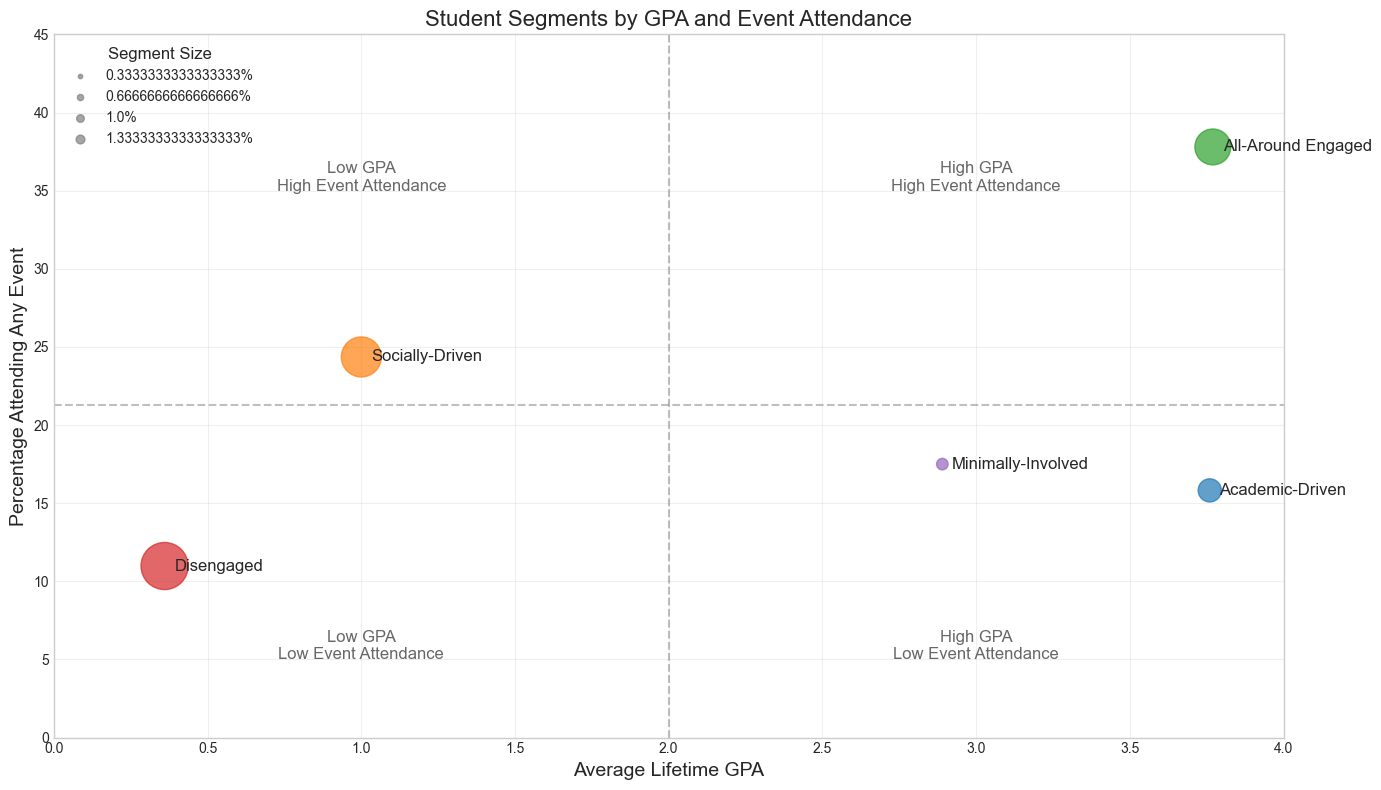

In [328]:
# -----------------------------------------------------------
# PLOT 1: Student Segments with GPA and Event Attendance
# This plot shows the relationship between our segments, GPA, 
# and event attendance, addressing questions 1 and 2
# -----------------------------------------------------------

plt.figure(figsize=(14, 8))

# Create a dataframe with segment information
segments_df = pd.DataFrame({
    'Segment': ['Disengaged', 'Socially-Driven', 'All-Around Engaged', 'Academic-Driven', 'Minimally-Involved'],
    'Percentage': [38.4, 27.7, 22.3, 9.3, 2.3],
    'GPA': [0.36, 1.00, 3.77, 3.76, 2.89],
    'Event_Attendance': [10.98, 24.36, 37.80, 15.82, 17.50]
})

# Create a scatter plot with size representing segment percentage
plt.scatter(
    segments_df['GPA'], 
    segments_df['Event_Attendance'],
    s=segments_df['Percentage'] * 30,  # Scale for visibility
    c=[segment_colors[segment] for segment in segments_df['Segment']],
    alpha=0.7
)

# Add segment labels
for i, row in segments_df.iterrows():
    plt.annotate(
        row['Segment'],
        xy=(row['GPA'], row['Event_Attendance']),
        xytext=(7, 0),
        textcoords='offset points',
        fontsize=12,
        va='center'
    )

# Add a size legend
sizes = [10, 20, 30, 40]
percentages = [s/30 for s in sizes]
plt.scatter([], [], s=sizes[0], c='gray', alpha=0.7, label=f'{percentages[0]}%')
plt.scatter([], [], s=sizes[1], c='gray', alpha=0.7, label=f'{percentages[1]}%')
plt.scatter([], [], s=sizes[2], c='gray', alpha=0.7, label=f'{percentages[2]}%')
plt.scatter([], [], s=sizes[3], c='gray', alpha=0.7, label=f'{percentages[3]}%')
plt.legend(title='Segment Size', loc='upper left', title_fontsize=12)

# Add quadrant lines and labels
plt.axvline(x=2.0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=21.27, color='gray', linestyle='--', alpha=0.5)  # Using overall event attendance rate

plt.text(1.0, 35, 'Low GPA\nHigh Event Attendance', ha='center', fontsize=12, alpha=0.7)
plt.text(3.0, 35, 'High GPA\nHigh Event Attendance', ha='center', fontsize=12, alpha=0.7)
plt.text(1.0, 5, 'Low GPA\nLow Event Attendance', ha='center', fontsize=12, alpha=0.7)
plt.text(3.0, 5, 'High GPA\nLow Event Attendance', ha='center', fontsize=12, alpha=0.7)

plt.xlim(0, 4.0)
plt.ylim(0, 45)
plt.xlabel('Average Lifetime GPA', fontsize=14)
plt.ylabel('Percentage Attending Any Event', fontsize=14)
plt.title('Student Segments by GPA and Event Attendance', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('segment_gpa_event_attendance.png', dpi=300, bbox_inches='tight')

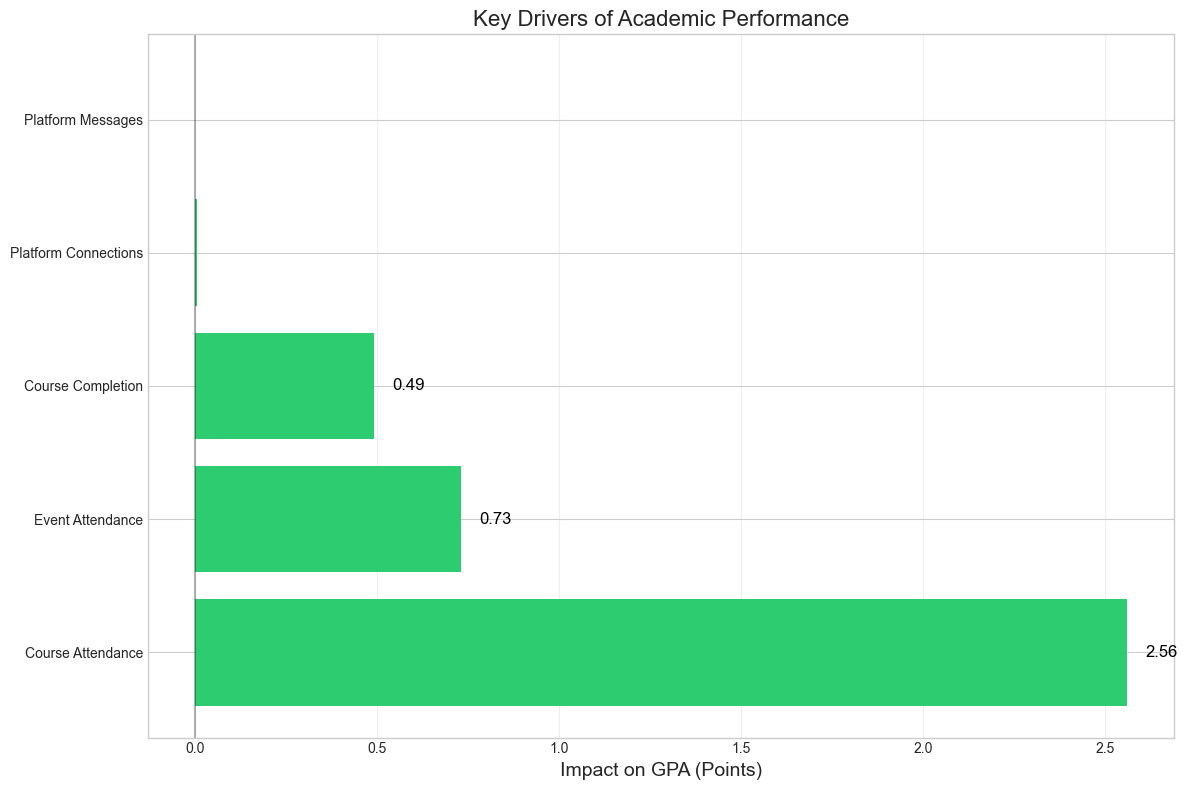

In [329]:
# -----------------------------------------------------------
# PLOT 2: Key Drivers of Academic Performance
# This plot visualizes the factors most strongly associated with GPA,
# addressing question 2 about what drives student motivation
# -----------------------------------------------------------

plt.figure(figsize=(12, 8))

# Create data for the plot based on regression results
drivers = {
    'Course Attendance': 2.56,
    'Course Completion': 0.49,
    'Platform Connections': 0.003,
    'Platform Messages': -0.002,
    'Event Attendance': 0.73  # This is the GPA difference (2.24 - 1.52) from binary analysis
}

# Sort by impact
drivers = {k: v for k, v in sorted(drivers.items(), key=lambda item: abs(item[1]), reverse=True)}

# Create colors based on positive/negative impact
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in drivers.values()]

# Create bar chart
plt.barh(list(drivers.keys()), list(drivers.values()), color=colors)

# Add value labels
for i, v in enumerate(drivers.values()):
    if abs(v) >= 0.01:  # Only show labels for visible values
        plt.text(v + 0.05 if v >= 0 else v - 0.25, i, f'{v:.2f}', 
                 va='center', fontsize=12, color='black' if v >= 0 else 'white')

plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Impact on GPA (Points)', fontsize=14)
plt.title('Key Drivers of Academic Performance', fontsize=16)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('gpa_drivers.png', dpi=300, bbox_inches='tight')


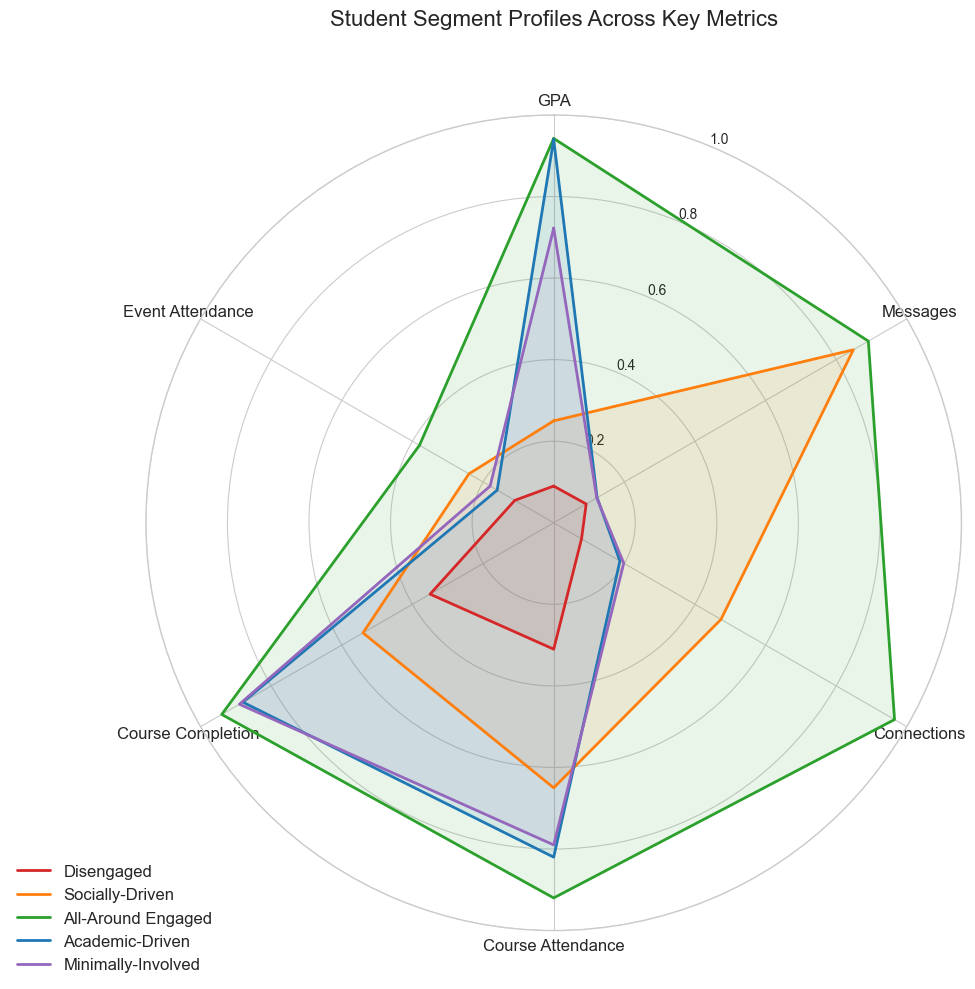

In [330]:
# -----------------------------------------------------------
# PLOT 3: Student Segment Profile Radar Chart
# This plot shows the distinct characteristics of each segment,
# addressing question 1 about meaningful student groups
# -----------------------------------------------------------

# Metrics to include in the radar chart
metrics = ['GPA', 'Messages', 'Connections', 'Course Attendance', 'Course Completion', 'Event Attendance']

# Prepare data for radar chart
radar_data = {
    'Disengaged': [0.36/4.0, 1.84/20.0, 9.46/120.0, 0.31, 0.35, 0.11],
    'Socially-Driven': [1.00/4.0, 16.97/20.0, 56.85/120.0, 0.65, 0.54, 0.24],
    'All-Around Engaged': [3.77/4.0, 17.82/20.0, 115.82/120.0, 0.92, 0.94, 0.38],
    'Academic-Driven': [3.76/4.0, 2.46/20.0, 22.50/120.0, 0.82, 0.88, 0.16],
    'Minimally-Involved': [2.89/4.0, 2.44/20.0, 23.81/120.0, 0.79, 0.89, 0.18]
}

# Number of variables
N = len(metrics)

# Create angle for each category
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Create figure
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))

# Draw one segment at a time
for segment, values in radar_data.items():
    # Add values for the segment
    values += values[:1]  # Close the loop
    
    # Plot values
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=segment, color=segment_colors[segment])
    ax.fill(angles, values, alpha=0.1, color=segment_colors[segment])

# Fix axis to go in the right order and start at 12 o'clock
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12)

# Set y limits
ax.set_ylim(0, 1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)

plt.title('Student Segment Profiles Across Key Metrics', fontsize=16, y=1.1)
plt.tight_layout()
plt.savefig('segment_radar_chart.png', dpi=300, bbox_inches='tight')


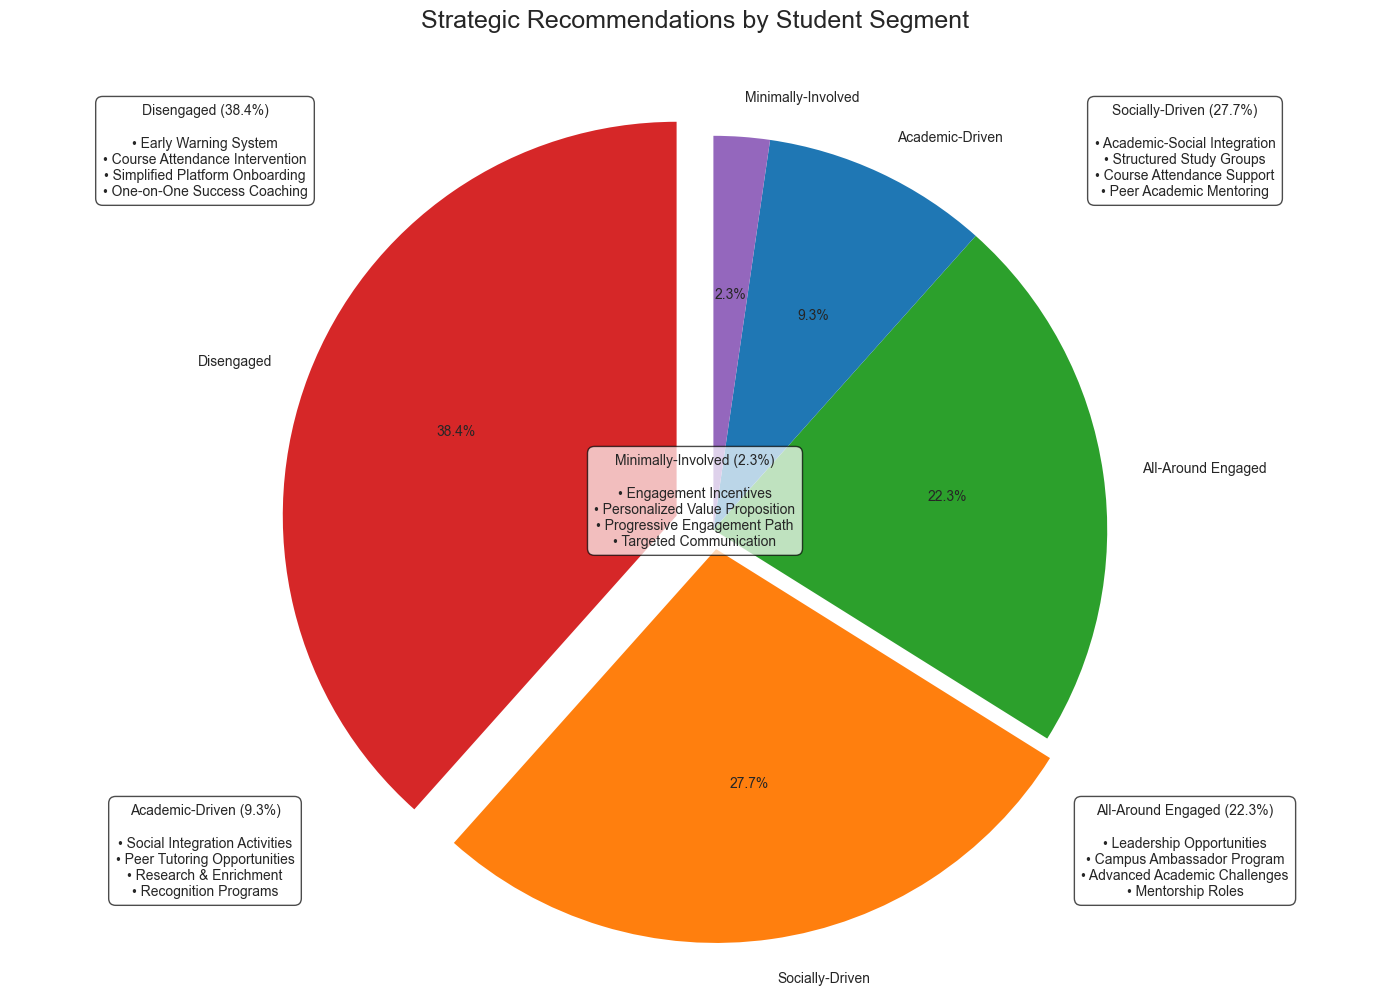

In [331]:
# -----------------------------------------------------------
# PLOT 4: Strategic Recommendations by Segment
# This plot provides a visual summary of recommendations for each segment,
# addressing question 3 about strategic recommendations
# -----------------------------------------------------------

plt.figure(figsize=(14, 10))

# Segment information
segments = ['Disengaged', 'Socially-Driven', 'All-Around Engaged', 'Academic-Driven', 'Minimally-Involved']
sizes = [38.4, 27.7, 22.3, 9.3, 2.3]  # Percentages
explode = (0.1, 0.05, 0, 0, 0)  # Explode the largest segments slightly

# Create the pie chart
plt.pie(sizes, explode=explode, labels=segments, colors=[segment_colors[s] for s in segments],
        autopct='%1.1f%%', shadow=False, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add recommendations for each segment
recommendations = {
    'Disengaged (38.4%)': [
        '• Early Warning System',
        '• Course Attendance Intervention',
        '• Simplified Platform Onboarding',
        '• One-on-One Success Coaching'
    ],
    'Socially-Driven (27.7%)': [
        '• Academic-Social Integration',
        '• Structured Study Groups',
        '• Course Attendance Support',
        '• Peer Academic Mentoring'
    ],
    'All-Around Engaged (22.3%)': [
        '• Leadership Opportunities',
        '• Campus Ambassador Program',
        '• Advanced Academic Challenges',
        '• Mentorship Roles'
    ],
    'Academic-Driven (9.3%)': [
        '• Social Integration Activities',
        '• Peer Tutoring Opportunities',
        '• Research & Enrichment',
        '• Recognition Programs'
    ],
    'Minimally-Involved (2.3%)': [
        '• Engagement Incentives',
        '• Personalized Value Proposition',
        '• Progressive Engagement Path',
        '• Targeted Communication'
    ]
}

# Position the recommendation text boxes
positions = [
    (0.15, 0.85),  # Disengaged
    (0.85, 0.85),  # Socially-Driven
    (0.85, 0.15),  # All-Around Engaged
    (0.15, 0.15),  # Academic-Driven
    (0.5, 0.5)     # Minimally-Involved
]

# Add the recommendations text boxes
for i, segment in enumerate(recommendations.keys()):
    box_text = f"{segment}\n\n" + "\n".join(recommendations[segment])
    
    props = dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7)
    plt.figtext(positions[i][0], positions[i][1], box_text, fontsize=10,
                horizontalalignment='center', verticalalignment='center',
                bbox=props)

plt.title('Strategic Recommendations by Student Segment', fontsize=18, y=1.05)
plt.tight_layout()
plt.savefig('segment_recommendations.png', dpi=300, bbox_inches='tight')

/var/folders/9x/l1n4s3y105b8c9_zlczmmcdm0000gn/T/ipykernel_93654/2204241119.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(segments, rotation=45, ha='right', fontsize=12)
/var/folders/9x/l1n4s3y105b8c9_zlczmmcdm0000gn/T/ipykernel_93654/2204241119.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(segments, rotation=45, ha='right', fontsize=12)
/var/folders/9x/l1n4s3y105b8c9_zlczmmcdm0000gn/T/ipykernel_93654/2204241119.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(segments, rotation=45, ha='right', fontsize=12)
/var/folders/9x/l1n4s3y105b8c9_zlczmmcdm0000gn/T/ipykernel_93654/2204241119.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of 

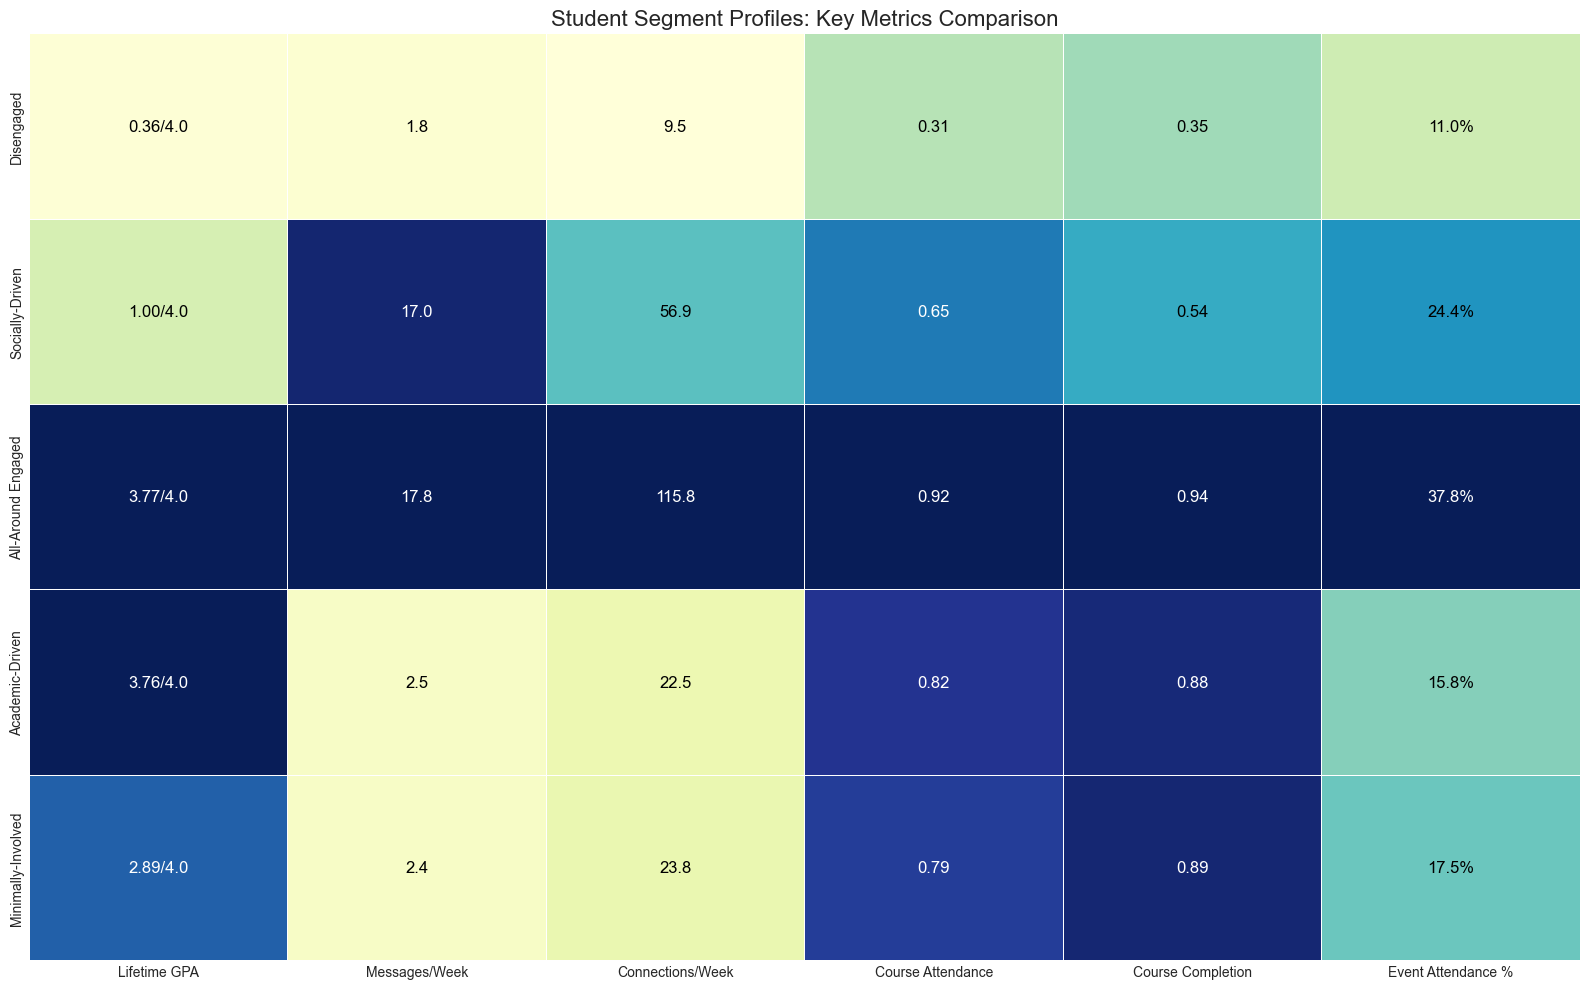

<Figure size 1600x800 with 0 Axes>

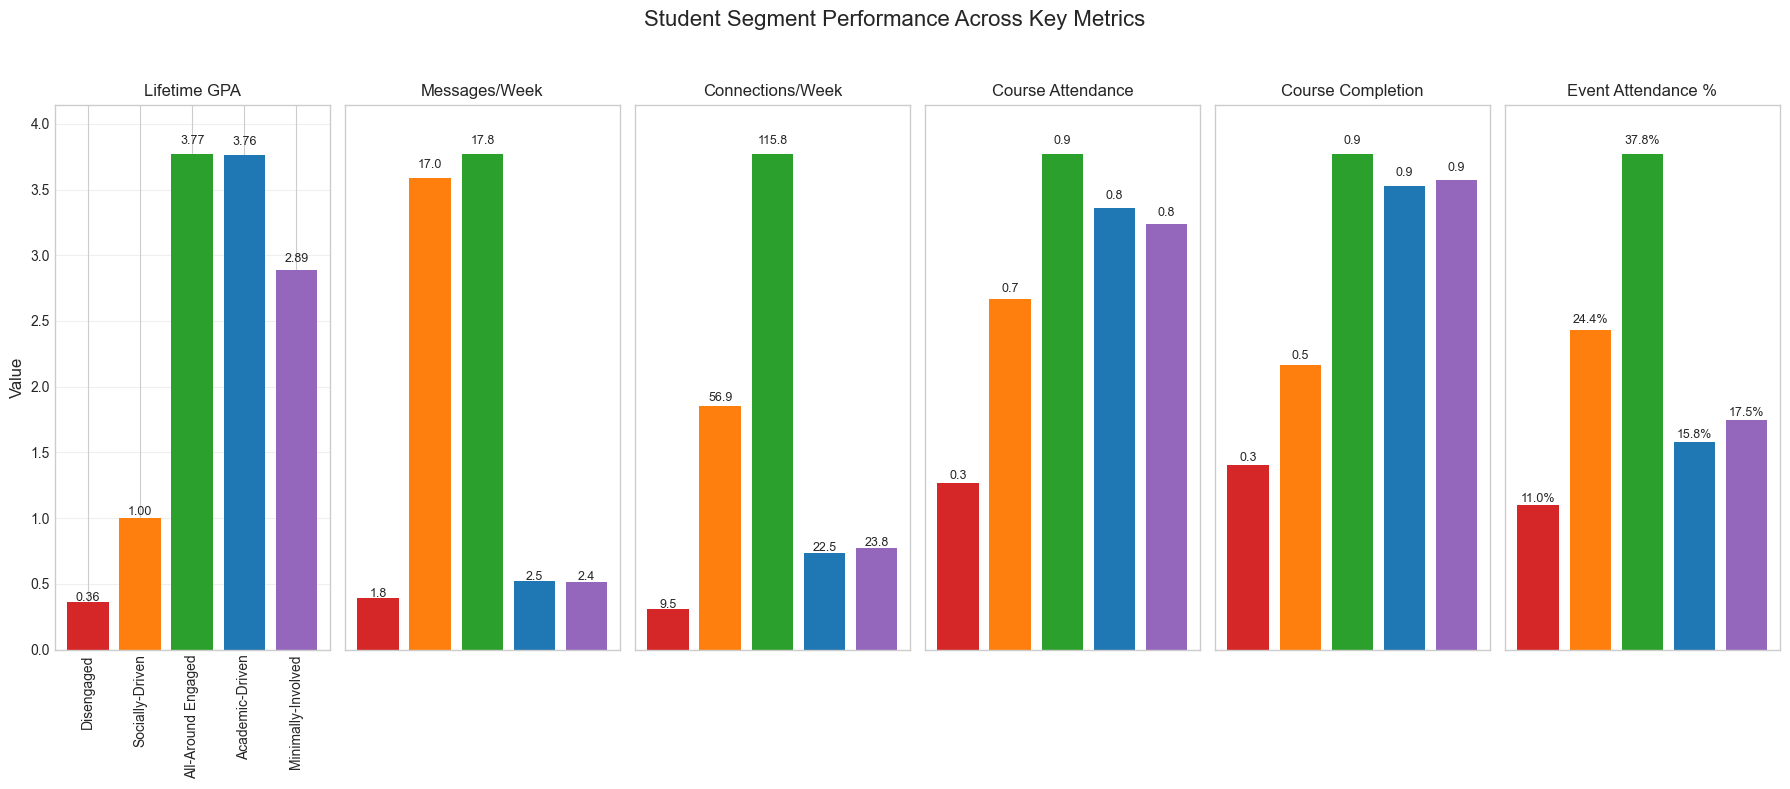

<Figure size 1800x1200 with 0 Axes>

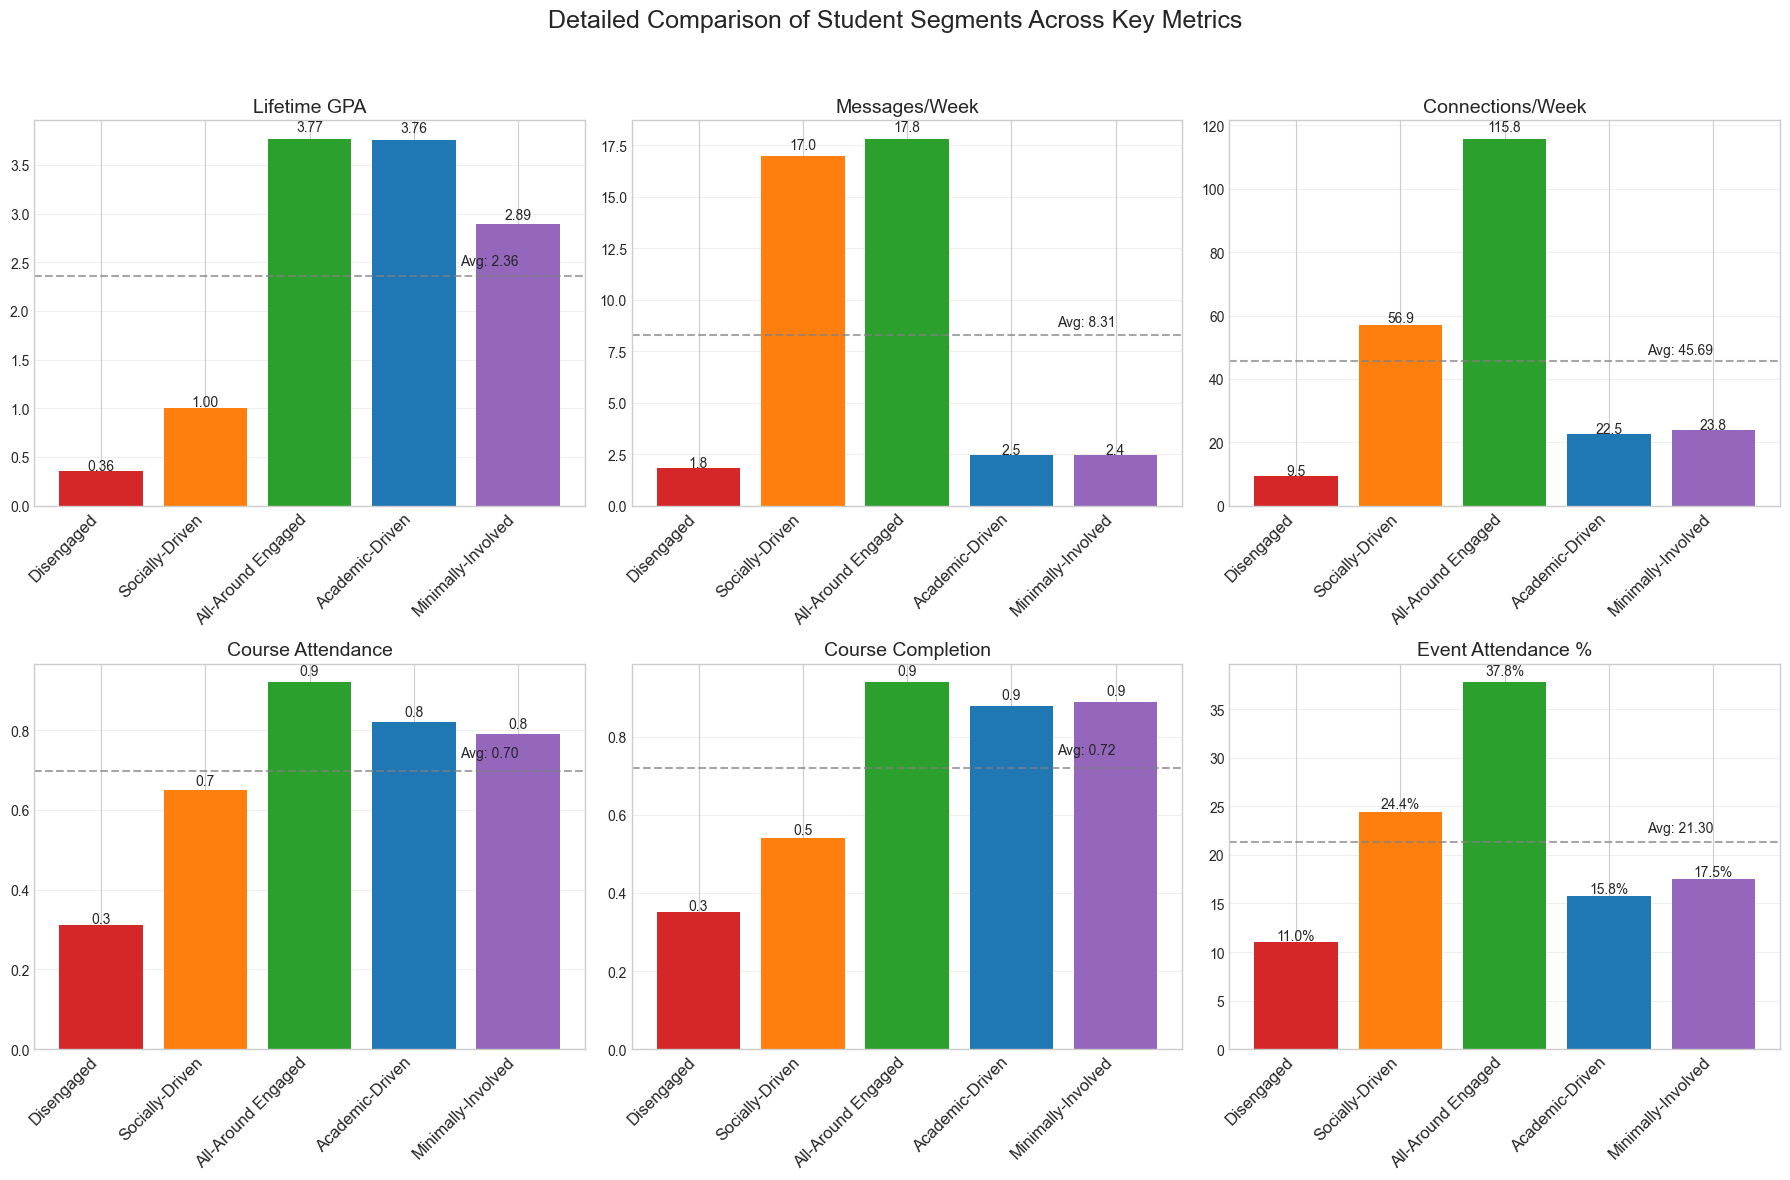

In [332]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set overall style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Define a custom color palette for segments
segment_colors = {
    'Academic-Driven': '#1f77b4',      # Blue
    'Socially-Driven': '#ff7f0e',      # Orange
    'All-Around Engaged': '#2ca02c',   # Green
    'Disengaged': '#d62728',           # Red
    'Minimally-Involved': '#9467bd'    # Purple
}

# Create a DataFrame with the segment profiles
segments = ['Disengaged', 'Socially-Driven', 'All-Around Engaged', 'Academic-Driven', 'Minimally-Involved']
metrics = ['Lifetime GPA', 'Messages/Week', 'Connections/Week', 'Course Attendance', 'Course Completion', 'Event Attendance %']

# Original data (not normalized)
data = [
    [0.36, 1.84, 9.46, 0.31, 0.35, 11.0],  # Disengaged
    [1.00, 16.97, 56.85, 0.65, 0.54, 24.4], # Socially-Driven
    [3.77, 17.82, 115.82, 0.92, 0.94, 37.8], # All-Around Engaged
    [3.76, 2.46, 22.50, 0.82, 0.88, 15.8],  # Academic-Driven
    [2.89, 2.44, 23.81, 0.79, 0.89, 17.5]   # Minimally-Involved
]

# Create the DataFrame
df = pd.DataFrame(data, index=segments, columns=metrics)

# Create a more interpretable heatmap-style visualization
plt.figure(figsize=(16, 10))

# Create a normalized version for the heatmap colors
# To normalize, we'll divide each column by its maximum value
df_norm = df.copy()
for col in df_norm.columns:
    df_norm[col] = df_norm[col] / df_norm[col].max()

# Plot the heatmap
ax = sns.heatmap(df_norm, annot=False, cmap="YlGnBu", linewidths=0.5, cbar=False)

# Add the actual values as text
for i in range(len(df.index)):
    for j in range(len(df.columns)):
        # Format the value based on the column
        if df.columns[j] == 'Lifetime GPA':
            text = f"{df.iloc[i, j]:.2f}/4.0"
        elif df.columns[j] in ['Course Attendance', 'Course Completion']:
            text = f"{df.iloc[i, j]:.2f}"
        elif df.columns[j] == 'Event Attendance %':
            text = f"{df.iloc[i, j]:.1f}%"
        else:
            text = f"{df.iloc[i, j]:.1f}"
        
        # Add text with white or black color depending on background darkness
        text_color = 'white' if df_norm.iloc[i, j] > 0.7 else 'black'
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', fontsize=12, color=text_color)

# Add a title and labels
plt.title('Student Segment Profiles: Key Metrics Comparison', fontsize=16)
plt.tight_layout()

# Create a parallel coordinates plot as an alternative visualization
plt.figure(figsize=(16, 8))

# Melt the dataframe for easier plotting
df_melt = df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')

# Create a separate subplot for each metric to better handle different scales
fig, axes = plt.subplots(1, len(metrics), figsize=(18, 8), sharey=False)
fig.subplots_adjust(wspace=0.1)  # Reduce space between subplots

# For each metric, create a separate plot
for i, metric in enumerate(metrics):
    # Get data for this metric
    metric_data = df[metric]
    
    # Determine y-range for this metric
    min_val = metric_data.min() * 0.9  # Add 10% padding
    max_val = metric_data.max() * 1.1
    
    # Create bars for each segment
    axes[i].bar(range(len(segments)), metric_data, color=[segment_colors[s] for s in segments])
    
    # Add segment labels to x-axis for the first subplot only
    if i == 0:
        axes[i].set_ylabel('Value', fontsize=12)
        # Add segment labels vertically
        axes[i].set_xticks(range(len(segments)))
        axes[i].set_xticklabels(segments, rotation=90, fontsize=10)
    else:
        # Remove y-axis for other subplots to avoid clutter
        axes[i].set_yticks([])
        axes[i].set_xticks([])
    
    # Add metric title
    axes[i].set_title(metric, fontsize=12)
    
    # Add value labels on top of bars
    for j, value in enumerate(metric_data):
        if metric == 'Event Attendance %':
            label = f"{value:.1f}%"
        elif metric == 'Lifetime GPA':
            label = f"{value:.2f}"
        else:
            label = f"{value:.1f}"
        axes[i].text(j, value * 1.02, label, ha='center', fontsize=9)
    
    # Set y-limits
    axes[i].set_ylim(0, max_val)
    
    # Add grid lines
    axes[i].grid(axis='y', alpha=0.3)

# Add an overall title
fig.suptitle('Student Segment Performance Across Key Metrics', fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for title

# Save the plots
plt.savefig('segment_metrics_comparison.png', dpi=300, bbox_inches='tight')

# Create a faceted bar chart for even clearer comparison
plt.figure(figsize=(18, 12))

# Setup a 2x3 grid of subplots (one for each metric)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()  # Flatten to make indexing easier

# For each metric, create a separate subplot
for i, metric in enumerate(metrics):
    # Create a bar chart in the corresponding subplot
    ax = axes[i]
    bars = ax.bar(segments, df[metric], color=[segment_colors[s] for s in segments])
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        if metric == 'Event Attendance %':
            label = f"{height:.1f}%"
        elif metric == 'Lifetime GPA':
            label = f"{height:.2f}"
        else:
            label = f"{height:.1f}"
        ax.text(bar.get_x() + bar.get_width()/2., height * 1.02, label, ha='center', fontsize=10)
    
    # Add a title and format the subplot
    ax.set_title(metric, fontsize=14)
    ax.set_xticklabels(segments, rotation=45, ha='right', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    # Add average line
    avg = df[metric].mean()
    ax.axhline(y=avg, color='gray', linestyle='--', alpha=0.7)
    ax.text(len(segments)-1, avg*1.05, f'Avg: {avg:.2f}', fontsize=10, ha='right')

# Add an overall title
fig.suptitle('Detailed Comparison of Student Segments Across Key Metrics', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for title

# Save the plot
plt.savefig('segment_detailed_comparison.png', dpi=300, bbox_inches='tight')